## Question 8: Give insights on the racing on what made a team win or underperform in the race.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob 
import os 
from datetime import datetime, timedelta
import math

# **Do not rerun this block** -- combining the csvs (DR)

#load the folder with the downsampled logs
 
folder_path = r'C:\Users\matsa\OneDrive\Υπολογιστής\SailGP\SGP Data challenge VS\SGP_Data_Challenge\Data\Boat_logs_Downsampled'

all_files = os.listdir(folder_path)

# Filter out non-CSV files
csv_files = [f for f in all_files if f.endswith('.csv')]

# Create a list to hold the downsampled dataframes
df_list = []

for csv in csv_files:
    file_path = os.path.join(folder_path, csv)
    try:
        # Try reading the file using default UTF-8 encoding
        df = pd.read_csv(file_path)
        df_list.append(df)
    except UnicodeDecodeError:
        try:
            # If UTF-8 fails, try reading the file using UTF-16 encoding with tab separator
            df = pd.read_csv(file_path, sep='\t', encoding='utf-16')
            df_list.append(df)
        except Exception as e:
            print(f"Could not read file {csv} because of error: {e}")
    except Exception as e:
        print(f"Could not read file {csv} because of error: {e}")

# Concatenate all data into one DataFrame
df = pd.concat(df_list, ignore_index=False)
# Save the final result to a new CSV file
df.to_csv(os.path.join(folder_path, 'combined_file.csv'), index=False)

# **Start here** 
read file and create dataframes needed
df_merged --> r=all combined log with the results and the marks location

**Read combined_file.csv**

In [3]:
#csv path - better run with combined downsampled data
csv_path = r'C:\Users\matsa\OneDrive\Υπολογιστής\SailGP\SGP Data challenge VS\SGP_Data_Challenge\Data\Boat_logs_Downsampled\combined_file.csv'
df= pd.read_csv(csv_path)
df["DATETIME"] = pd.to_datetime(df["TIME_LOCAL_unk"])

In [4]:
df['TWA']=df['TWA_SGP_deg'].abs()
df['TTL']=df['PC_TTK_s'].abs()   #time to line
df.loc[df['BOAT'] == 'USA', 'LENGTH_RH_S_mm'] *= -1 #was counting different signs for the USA

df['RH']=(df['LENGTH_RH_P_mm']+df['LENGTH_RH_S_mm'])/2  #calculates an average RH 
df['time_diff'] = df["DATETIME"].diff().dt.total_seconds()  #difference between concecutive time points
df['acc']=df['BOAT_SPEED_km_h_1'].diff()/df["time_diff"]  #acceleration 

df = df[df['BOAT'] != "CAN"] #excluding CAN


#Flying

In [5]:
df['flying'] = (df['RH'] > 1).astype(int)

**TWS BINS**

In [6]:
bin_width = 4
min_tws = int(df['TWS_SGP_km_h_1'].min())
max_tws = int(df['TWS_SGP_km_h_1'].max())

# Create bins with range from min to max, every 2 kmh
df['tws_bins']=pd.cut(df['TWS_SGP_km_h_1'], bins=list(range(min_tws, max_tws + bin_width, bin_width)))


**race results column added to df, as 'result'**

In [7]:
race_results = {
    "25011905": ["AUS", "GBR", "ITA", "NZL", "ESP", "GER", "BRA", "DEN", "USA", "SUI", "CAN"],
    "25011906": ["DEN", "AUS", "ESP", "GBR", "BRA", "NZL", "GER", "USA", "ITA", "SUI", "CAN"],
    "25011907": ["DEN", "NZL", "ESP", "SUI", "GER", "GBR", "BRA", "ITA", "USA", "AUS"],
    "25011908": ["AUS", "ESP", "GBR"]
}

# to DataFrame
results_df = pd.DataFrame([
    [race, boat, rank+1]  # Rank is assigned as 1-based index (1st place, 2nd place, etc.)
    for race, boats in race_results.items()
    for rank, boat in enumerate(boats)
], columns=["TRK_RACE_NUM_unk", "BOAT", "result"])

# Ensure race number is numeric for proper merging
results_df["TRK_RACE_NUM_unk"] = results_df["TRK_RACE_NUM_unk"].astype(int)

# Merge the results with the existing DataFrame (`df`)
df = df.merge(results_df, on=["TRK_RACE_NUM_unk", "BOAT"], how="left")

In [8]:
df.columns

Index(['BOAT', 'TIME_LOCAL_unk', 'LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk',
       'BOAT_SPEED_km_h_1', 'GPS_SOG_km_h_1', 'HEADING_deg', 'TWA_SGP_deg',
       'TWS_SGP_km_h_1', 'TWD_SGP_deg', 'AWA_SGP_deg', 'RATE_YAW_deg_s_1',
       'GPS_COG_deg', 'LEEWAY_deg', 'VMG_km_h_1', 'ANGLE_CA1_deg',
       'ANGLE_CA2_deg', 'ANGLE_CA3_deg', 'ANGLE_CA4_deg', 'ANGLE_CA5_deg',
       'ANGLE_CA6_deg', 'ANGLE_WING_TWIST_deg', 'ANGLE_WING_ROT_deg',
       'PITCH_deg', 'HEEL_deg', 'LENGTH_RH_P_mm', 'LENGTH_RH_S_mm',
       'LENGTH_RH_BOW_mm', 'ANGLE_RUDDER_deg', 'ANGLE_RUD_AVG_deg',
       'ANGLE_RUD_DIFF_TACK_deg', 'ANGLE_DB_RAKE_P_deg', 'ANGLE_DB_RAKE_S_deg',
       'ANGLE_DB_CANT_P_deg', 'ANGLE_DB_CANT_S_deg', 'TRK_LEG_NUM_TOT_unk',
       'TRK_LEG_NUM_unk', 'TRK_RACE_NUM_unk', 'PC_TTS_s', 'PC_TTK_s',
       'PC_TTB_s', 'PC_DTB_m', 'PC_DTL_m', 'PC_TTM_s', 'TWD_avg', 'DATETIME',
       'TWA', 'TTL', 'RH', 'time_diff', 'acc', 'flying', 'tws_bins', 'result'],
      dtype='object')

In [9]:
#colours
custom_palette = {
    'NZL': 'black',            
    'BRA': '#45ff84',          
    'CAN': '#FF6347',          
    'ESP': '#FFF700',          
    'GER': '#FFA500',          
    'ITA': '#FF46a2',       
    'AUS': '#008000',        
    'GBR': '#0000FF',        
    'DEN': '#800080',      
    'SUI': '#FF0000',         
    'USA': '#00BFFF' 
}

**Import marks' Lat Lon and merge them on the df**

In [10]:
csv_path = r'C:\Users\matsa\OneDrive\Υπολογιστής\SailGP\SGP Data challenge VS\SGP_Data_Challenge\Data\Course_Marks_2025-01-19.csv'
marks= pd.read_csv(csv_path)

# Ensure 'DATETIME' is in datetime format in both DataFrames
marks["DATETIME"] = pd.to_datetime(marks["DATETIME"]).dt.tz_localize(None)


In [11]:
# Add 13 hours
marks["DATETIME"] = marks["DATETIME"] + pd.Timedelta(hours=13)

In [12]:
marks["DATETIME"]

0        2025-01-19 14:00:01
1        2025-01-19 14:00:02
2        2025-01-19 14:00:03
3        2025-01-19 14:00:04
4        2025-01-19 14:00:05
                 ...        
111757   2025-01-19 17:32:21
111758   2025-01-19 17:32:22
111759   2025-01-19 17:32:23
111760   2025-01-19 17:32:24
111761   2025-01-19 17:32:25
Name: DATETIME, Length: 111762, dtype: datetime64[ns]

In [13]:
# Pivot the table to get separate columns for each mark's LATITUDE and LONGITUDE
marks_pivot = marks.pivot(index="DATETIME", columns="MARK", values=["LATITUDE_deg", "LONGITUDE_deg"])

# column names "LATITUDE_{MARK}" and "LONGITUDE_{MARK}"
marks_pivot.columns = [f"{col[0]}_{col[1]}" for col in marks_pivot.columns]

# Reset index to keep 'DATETIME' as a column
marks_pivot = marks_pivot.reset_index()


In [14]:
# Merge the marks data into df based on 'DATETIME' LATITUTE_deg LONGITUTE_deg refer to marks
df_merged = df.merge(marks_pivot, on="DATETIME", how="left")

# *haversine function - distance between coordinates*

In [15]:
def haversine(lat1, lon1, lat2, lon2):
     
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0
 
    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0
 
    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) +
         pow(math.sin(dLon / 2), 2) *
             math.cos(lat1) * math.cos(lat2));
    radius = 637600 #earth radius (meters)
    c = 2 * math.asin(math.sqrt(a))
    return radius * c

# df_merged includes distance to every mark at each timepoint

In [16]:
# List of latitude and longitude column pairs to compare against GPS_unk
location_columns = [
    ("LATITUDE_deg_FL1", "LONGITUDE_deg_FL1"),
    ("LATITUDE_deg_FL2", "LONGITUDE_deg_FL2"),
    ("LATITUDE_deg_LG1", "LONGITUDE_deg_LG1"),
    ("LATITUDE_deg_LG2", "LONGITUDE_deg_LG2"),
    ("LATITUDE_deg_M1", "LONGITUDE_deg_M1"),
    ("LATITUDE_deg_SL1", "LONGITUDE_deg_SL1"),
    ("LATITUDE_deg_SL2", "LONGITUDE_deg_SL2"),
    ("LATITUDE_deg_WG1", "LONGITUDE_deg_WG1"),
    ("LATITUDE_deg_WG2", "LONGITUDE_deg_WG2"),
]

# Compute distances from LATITUDE_GPS_unk / LONGITUDE_GPS_unk to each location set
for lat, lon in location_columns:
    df_merged[f"DISTANCE_TO_{lat.split('_')[-1]}"] = df_merged.apply(
        lambda row: haversine(row["LATITUDE_GPS_unk"], row["LONGITUDE_GPS_unk"],row[lat], row[lon]), axis=1)

# Display updated df_merged
#print(df_merged)

# get  race start times to find the distance to line, to M1  **at gun** time for each boat. 
at_gun --> data at the time of the starts bsp, dtl, ttl distance to m1, acceleration

at_gun_filtered --> excludes the final.

In [17]:
race_starttimes_timezone = [
    "2025-01-19T16:08:00",
    "2025-01-19T16:29:00",
    "2025-01-19T16:50:00",
    "2025-01-19T17:14:00"
]

race_starttimes = pd.DataFrame({"start_time": race_starttimes_timezone,
    "TRK_RACE_NUM_unk": df['TRK_RACE_NUM_unk'].unique()})

race_starttimes['start_time']
df["DATETIME"] = pd.to_datetime(df["DATETIME"]).dt.tz_localize(None) #to match the start times

In [18]:
race_starttimes

start_time  TRK_RACE_NUM_unk
0  2025-01-19T16:08:00        25011905.0
1  2025-01-19T16:29:00        25011906.0
2  2025-01-19T16:50:00        25011907.0
3  2025-01-19T17:14:00        25011908.0

In [19]:
at_gun=df_merged[df_merged["DATETIME"].isin(race_starttimes_timezone)][['DATETIME',"BOAT",'TRK_RACE_NUM_unk', 'BOAT_SPEED_km_h_1', 'TTL', 'PC_DTL_m','DISTANCE_TO_M1','acc']]
at_gun['race']=at_gun['TRK_RACE_NUM_unk'].apply(lambda x: int(str(x)[7])) #setting race as a number 

In [20]:
at_gun

DATETIME BOAT  TRK_RACE_NUM_unk  BOAT_SPEED_km_h_1   TTL  \
13   2025-01-19 16:08:00  AUS        25011905.0              79.88  0.00   
81   2025-01-19 16:29:00  AUS        25011906.0              59.81  0.50   
149  2025-01-19 16:50:00  AUS        25011907.0              42.37  0.65   
186  2025-01-19 17:14:00  AUS        25011908.0              73.80  0.70   
251  2025-01-19 16:08:00  BRA        25011905.0              49.48  2.00   
323  2025-01-19 16:29:00  BRA        25011906.0              49.33  0.40   
392  2025-01-19 16:50:00  BRA        25011907.0              29.78  0.80   
466  2025-01-19 16:08:00  DEN        25011905.0              61.09  1.15   
539  2025-01-19 16:29:00  DEN        25011906.0              66.06  0.90   
606  2025-01-19 16:50:00  DEN        25011907.0              58.88  1.35   
672  2025-01-19 16:08:00  ESP        25011905.0              71.38  2.70   
742  2025-01-19 16:29:00  ESP        25011906.0              47.74  2.10   
810  2025-01-19 16:50:00  ESP        25011907.0              35.38  2.80   
879  2025-01-19 17:14:00  ESP        25011908.0              67.28  2.50   
947  2025-01-19 16:08:00  GBR        25011905.0              66.37  1.40   
1015 2025-01-19 16:29:00  GBR        25011906.0              50.07  4.65   
1084 2025-01-19 16:50:00  GBR        25011907.0              38.51  0.90   
1155 2025-01-19 17:14:00  GBR        25011908.0              67.32  0.70   
1223 2025-01-19 16:08:00  GER        25011905.0              48.75  1.45   
1294 2025-01-19 16:29:00  GER        25011906.0              50.43  2.75   
1365 2025-01-19 16:50:00  GER        25011907.0              55.03  1.35   
1436 2025-01-19 16:08:00  ITA        25011905.0              68.36  1.25   
1506 2025-01-19 16:29:00  ITA        25011906.0              44.93  0.65   
1578 2025-01-19 16:50:00  ITA        25011907.0              44.55  0.80   
1652 2025-01-19 16:08:00  NZL        25011905.0              29.51  0.05   
1722 2025-01-19 16:29:00  NZL        25011906.0              19.09  8.50   
1792 2025-01-19 16:50:00  NZL        25011907.0              28.71  2.45   
1860 2025-01-19 16:08:00  SUI        25011905.0              36.27  1.50   
1938 2025-01-19 16:29:00  SUI        25011906.0              38.43  2.80   
2011 2025-01-19 16:50:00  SUI        25011907.0              35.06  0.70   
2081 2025-01-19 16:08:00  USA        25011905.0              39.51  3.35   
2155 2025-01-19 16:29:00  USA        25011906.0              66.47  1.10   
2226 2025-01-19 16:50:00  USA        25011907.0              56.66  0.50   

      PC_DTL_m  DISTANCE_TO_M1    acc  race  
13       13.70       49.474857  3.797     5  
81       21.58       49.492910  2.330     6  
149      17.81       49.487341  0.986     7  
186      27.68       50.209988  2.860     8  
251      41.33       51.391199  1.371     5  
323      16.39       48.574848  2.119     6  
392      12.76       48.530448  0.017     7  
466      34.09       50.241168  1.097     5  
539      31.49       51.757725  2.487     6  
606      35.72       50.866185  1.098     7  
672      85.33       55.069514  3.325     5  
742      51.29       51.773834  1.503     6  
810      54.77       52.220266  1.178     7  
879      73.56       52.032189  3.106     8  
947      42.08       51.669737  2.246     5  
1015     96.13       56.840592  1.283     6  
1084     21.64       49.332646  0.968     7  
1155     29.54       48.604028  3.444     8  
1223     38.15       50.129784  1.941     5  
1294     60.87       53.399825  1.773     6  
1365     39.65       52.087320  1.156     7  
1436     50.54       50.581507  2.509     5  
1506     29.31       49.122210  1.377     6  
1578     29.73       50.255310  1.173     7  
1652      7.84       47.599201 -0.795     5  
1722     26.97       50.854705  0.092     6  
1792     37.13       50.856782 -0.254     7  
1860     30.58       49.662710  0.592     5  
1938     54.52       52.031930  1.049     6  
2011     20.07       48.863274 -2.490     7  
2081 

# **Measure of performance for the start**

**Measure of performance for the start as sum of PC_DTL_m, distance to M1 of the day per boat.**
The ones with the smallest abs value wins.

**Filter out rows to exclude CAN and the FINAL**

In [21]:
filtered_at_gun = at_gun[(at_gun["DATETIME"] < "2025-01-19T17:10:00")]  # R5-7


In [22]:
filtered_at_gun = filtered_at_gun.drop(columns=["TRK_RACE_NUM_unk"])

**Start analytics all races**

In [23]:
start_analytics = filtered_at_gun.drop(columns=["DATETIME"]).groupby("BOAT").mean()


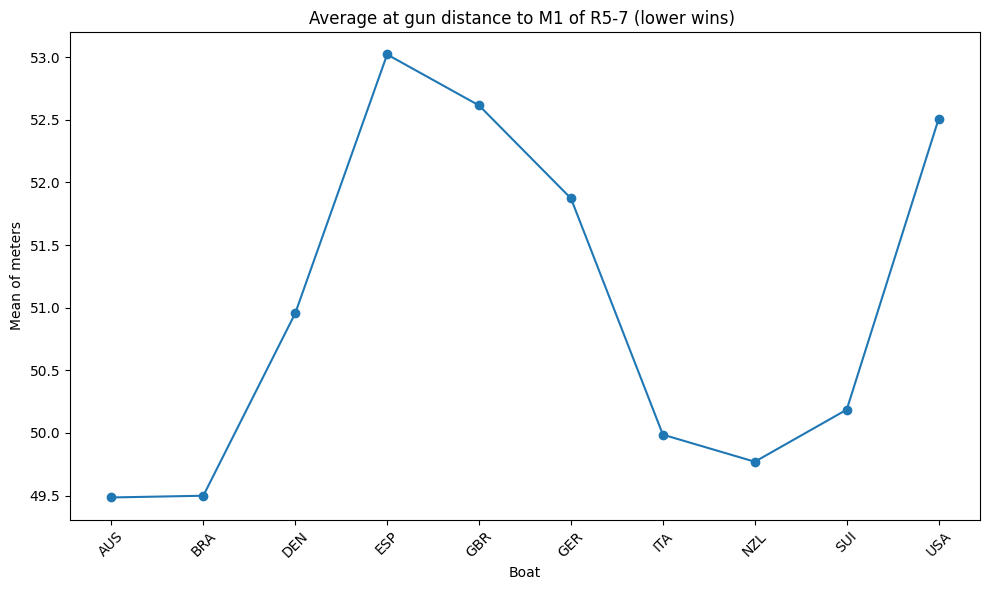

In [24]:
plt.figure(figsize=(10,6))

start_analytics['DISTANCE_TO_M1'].plot(kind='line', stacked=True, marker='o')

plt.title('Average at gun distance to M1 of R5-7 (lower wins) ')
plt.xlabel('Boat')
plt.ylabel('Mean of meters')
plt.xticks(ticks=range(len(start_analytics.index)), labels=start_analytics.index, rotation=45)
plt.tight_layout()

plt.show()

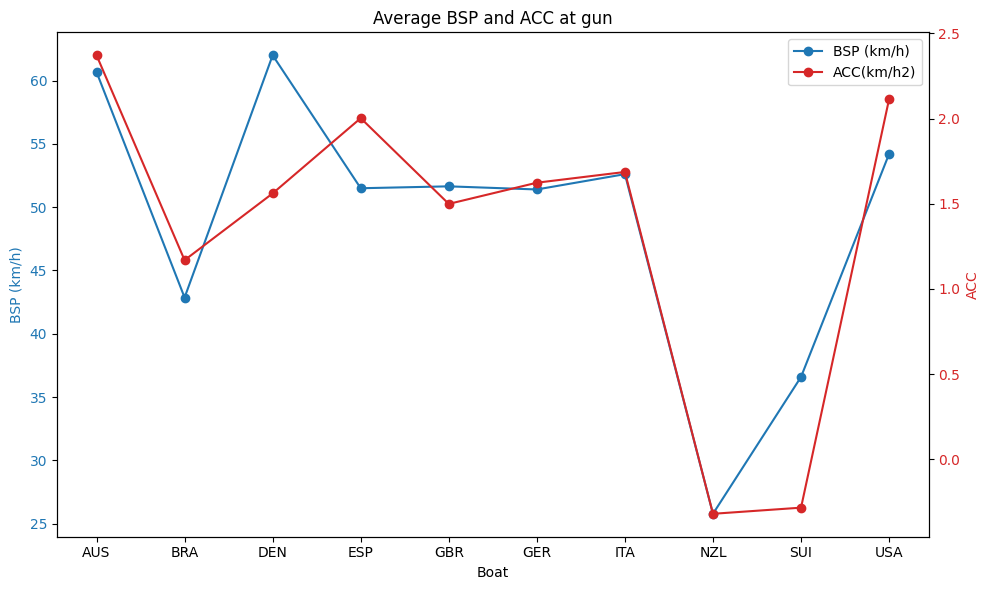

In [25]:
import matplotlib.pyplot as plt

# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot BOAT_SPEED_km_h_1 on the primary y-axis
ax1.plot(start_analytics.index, start_analytics['BOAT_SPEED_km_h_1'], marker='o', color='tab:blue', label='BSP (km/h)')
ax1.set_xlabel('Boat')
ax1.set_ylabel('BSP (km/h)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the secondary y-axis and plot 'acc'
ax2 = ax1.twinx()
ax2.plot(start_analytics.index, start_analytics['acc'], marker='o', color='tab:red', label='ACC(km/h2)')
ax2.set_ylabel('ACC', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title and rotate x-axis labels
plt.title('Average BSP and ACC at gun')
ax1.set_xticks(range(len(start_analytics.index)))
ax1.set_xticklabels(start_analytics.index)

# Add a legend that combines both lines
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()


**By race**

In [26]:
start_analytics_by_race=filtered_at_gun.drop(columns=["DATETIME"]).groupby(["race","BOAT"]).mean()

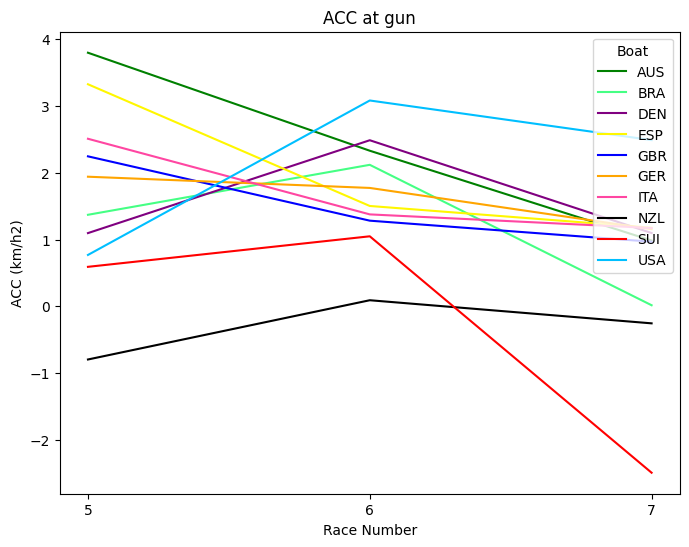

In [27]:
plt.figure(figsize=(8,6))
# Use seaborn's barplot to plot the count of tacks/jibes for each TRK_RACE_NUM_unk and BOAT combination
sns.lineplot(x="race", y='acc', hue="BOAT", data=start_analytics_by_race, palette=custom_palette)

# Adding labels and title
plt.title("ACC at gun")
plt.axis('tight')
plt.xlabel("Race Number")
plt.xticks(ticks=[5,6,7])
plt.ylabel("ACC (km/h2)")
plt.legend(title="Boat", loc="upper right")

plt.show()

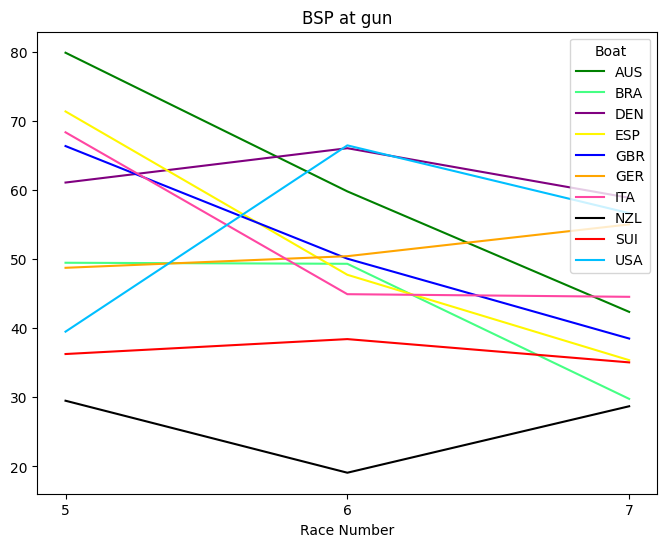

In [28]:
plt.figure(figsize=(8,6))
# Use seaborn's barplot to plot the count of tacks/jibes for each TRK_RACE_NUM_unk and BOAT combination
sns.lineplot(x="race", y='BOAT_SPEED_km_h_1', hue="BOAT", data=start_analytics_by_race, markers='o', palette=custom_palette)

# Adding labels and title
plt.title("BSP at gun")
plt.axis('tight')
plt.xlabel("Race Number")
plt.xticks(ticks=[5,6,7])
plt.ylabel("")
plt.legend(title="Boat", loc="upper right")

plt.show()

# **Number of manouvers per boat, per race** 

In [29]:
# Find the indices where TWA changes sign
sign_changes = (df_merged["TWA_SGP_deg"] * df_merged["TWA_SGP_deg"].shift(-1) < 0).values

In [30]:
df['TRK_RACE_NUM_unk'].unique()

array([25011905., 25011906., 25011907., 25011908.])

In [31]:
# Create a new series for tack/jibe condition
tackjibes_condition = (
    (df["TWA_SGP_deg"].shift(-1).multiply(df["TWA_SGP_deg"], fill_value=0) < 0)&(df["DATETIME"] > "2025-01-19T16:10:04") &  (df["DATETIME"] < "2025-01-19T17:14:00") &
    (df["time_diff"].shift(-1) <= 10)  # Check if time difference between points is <= 10sec
)

# Group by BOAT and count the number of True values
tackjibes_count = tackjibes_condition.groupby([df['TRK_RACE_NUM_unk'], df['BOAT']]).sum()


# Display the result
print(tackjibes_count)

TRK_RACE_NUM_unk  BOAT
25011905.0        AUS      5
                  BRA      6
                  DEN      7
                  ESP      7
                  GBR      7
                  GER      7
                  ITA      7
                  NZL      5
                  SUI      6
                  USA      6
25011906.0        AUS     10
                  BRA     11
                  DEN      8
                  ESP     13
                  GBR      8
                  GER      8
                  ITA     10
                  NZL     10
                  SUI     10
                  USA      8
25011907.0        AUS      4
                  BRA     11
                  DEN      8
                  ESP     10
                  GBR     10
                  GER     12
                  ITA     10
                  NZL      9
                  SUI      8
                  USA     12
25011908.0        AUS      1
                  ESP      1
                  GBR      1
dtype: int64


In [32]:
tackjibes_count_df = tackjibes_count.reset_index()

In [33]:
tackjibes_count_df

TRK_RACE_NUM_unk BOAT   0
0         25011905.0  AUS   5
1         25011905.0  BRA   6
2         25011905.0  DEN   7
3         25011905.0  ESP   7
4         25011905.0  GBR   7
5         25011905.0  GER   7
6         25011905.0  ITA   7
7         25011905.0  NZL   5
8         25011905.0  SUI   6
9         25011905.0  USA   6
10        25011906.0  AUS  10
11        25011906.0  BRA  11
12        25011906.0  DEN   8
13        25011906.0  ESP  13
14        25011906.0  GBR   8
15        25011906.0  GER   8
16        25011906.0  ITA  10
17        25011906.0  NZL  10
18        25011906.0  SUI  10
19        25011906.0  USA   8
20        25011907.0  AUS   4
21        25011907.0  BRA  11
22        25011907.0  DEN   8
23        25011907.0  ESP  10
24        25011907.0  GBR  10
25        25011907.0  GER  12
26        25011907.0  ITA  10
27        25011907.0  NZL   9
28        25011907.0  SUI   8
29        25011907.0  USA  12
30        25011908.0  AUS   1
31        25011908.0  ESP   1
32        25011908.0  GBR   1

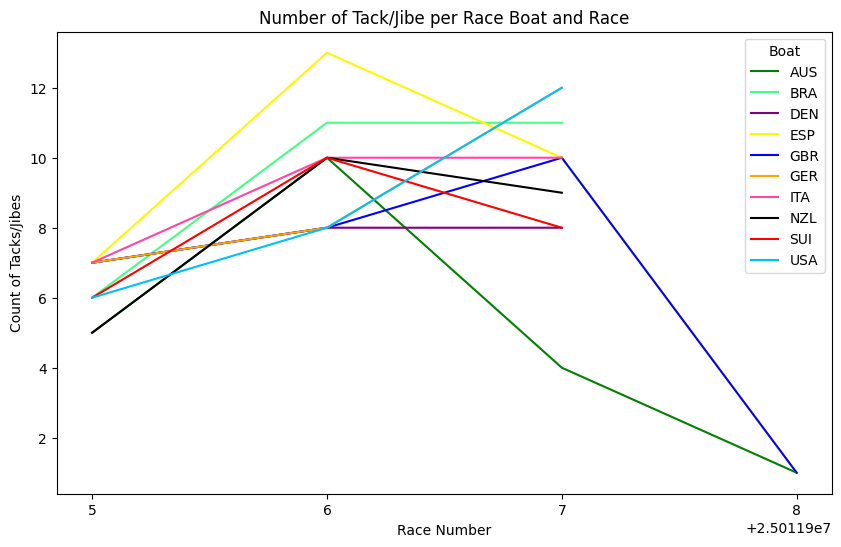

In [34]:
plt.figure(figsize=(10, 6))

# Use seaborn's barplot to plot the count of tacks/jibes for each TRK_RACE_NUM_unk and BOAT combination
sns.lineplot(x="TRK_RACE_NUM_unk", y=0, hue="BOAT", data=tackjibes_count_df, palette=custom_palette)

# Adding labels and title
plt.title("Number of Tack/Jibe per Race Boat and Race")
plt.axis('tight')
plt.xlabel("Race Number")
plt.ylabel("Count of Tacks/Jibes")
plt.legend(title="Boat", loc="upper right")
plt.xticks(ticks=range(int(tackjibes_count_df['TRK_RACE_NUM_unk'].min()), int(tackjibes_count_df['TRK_RACE_NUM_unk'].max()) + 1))
plt.show()

# **Boat averages per boat, leg, race**

In [35]:
boat_averages = df[
    ['BOAT',
     'BOAT_SPEED_km_h_1', 'acc',
     'TRK_RACE_NUM_unk',
     'TRK_LEG_NUM_unk',
     'PITCH_deg',
     'RH']
].groupby(by=['TRK_RACE_NUM_unk', 'TRK_LEG_NUM_unk', 'BOAT']).mean().round(1)

boat_averages.to_excel('8.boat_averages.xlsx')

**analytics per leg - UPWIND (3,5) DOWNWIND(2,4,6) REACHING(1,7)**


In [36]:
df.loc[df['TRK_LEG_NUM_unk'].isin([2, 4, 6]), 'leg'] = 'Downwind'
df.loc[df['TRK_LEG_NUM_unk'].isin([3, 5]), 'leg'] = 'Upwind'
df.loc[df['TRK_LEG_NUM_unk'].isin([1, 7]), 'leg'] = 'Reaching'

race_leg_averages=df[
    ['BOAT',
     'BOAT_SPEED_km_h_1',
     'TRK_RACE_NUM_unk',
     'PITCH_deg','HEEL_deg',
     'RH','leg']
].groupby(by=['TRK_RACE_NUM_unk', 'leg','BOAT']).mean().round(1)

C:\Users\matsa\AppData\Local\Temp\ipykernel_23104\1553502752.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Downwind' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['TRK_LEG_NUM_unk'].isin([2, 4, 6]), 'leg'] = 'Downwind'


In [37]:
#race_leg_averages.to_excel("8. race_leg_averages.xlsx")

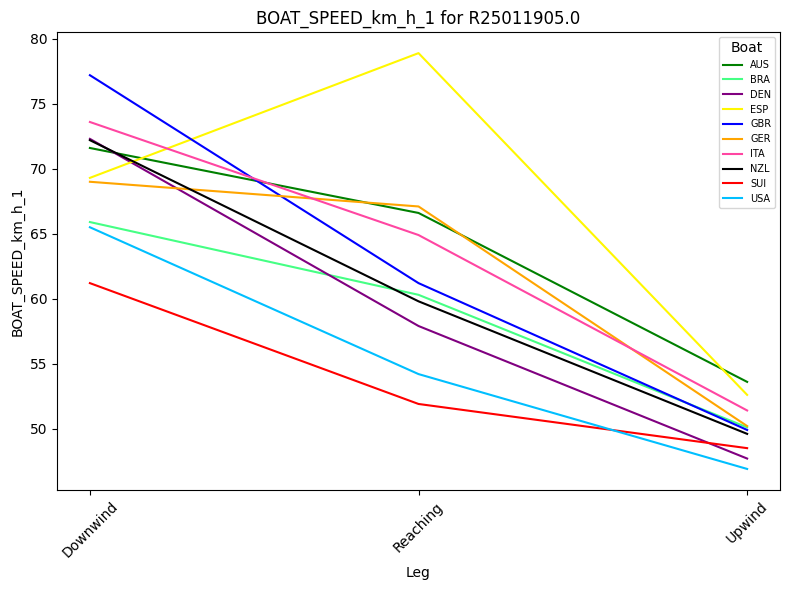

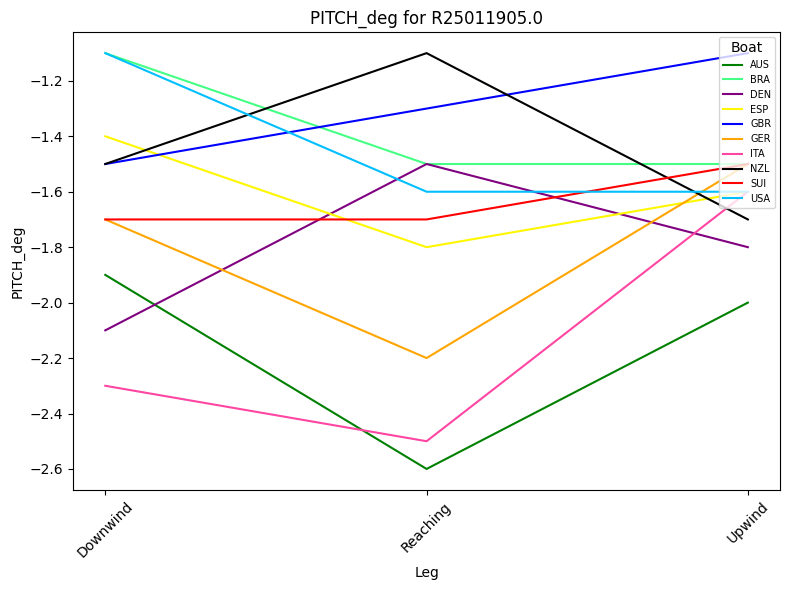

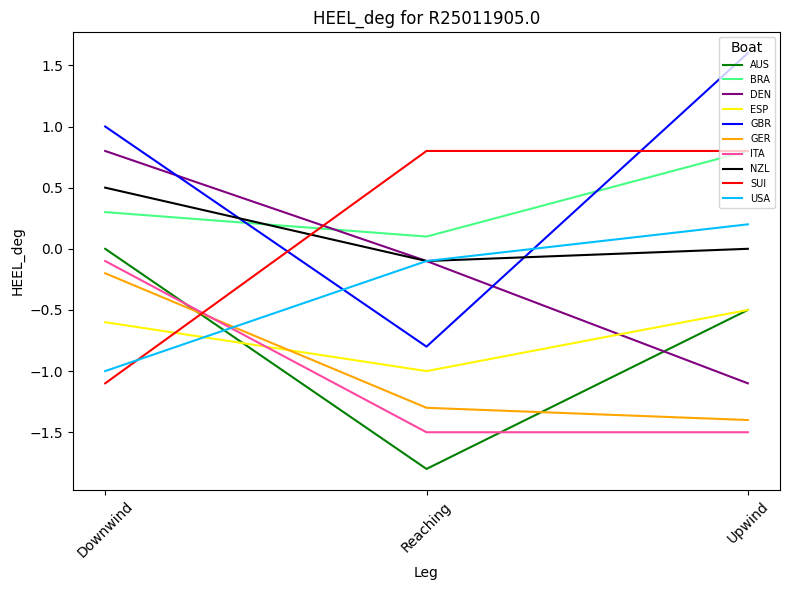

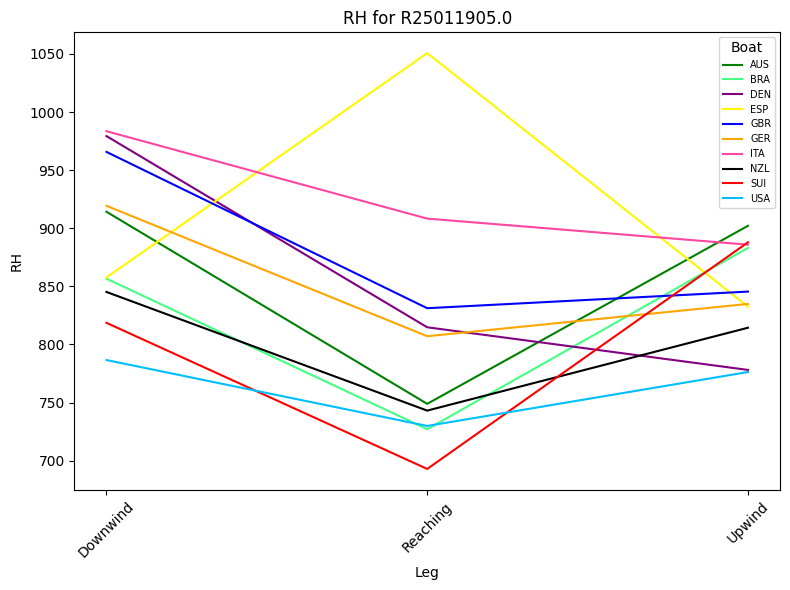

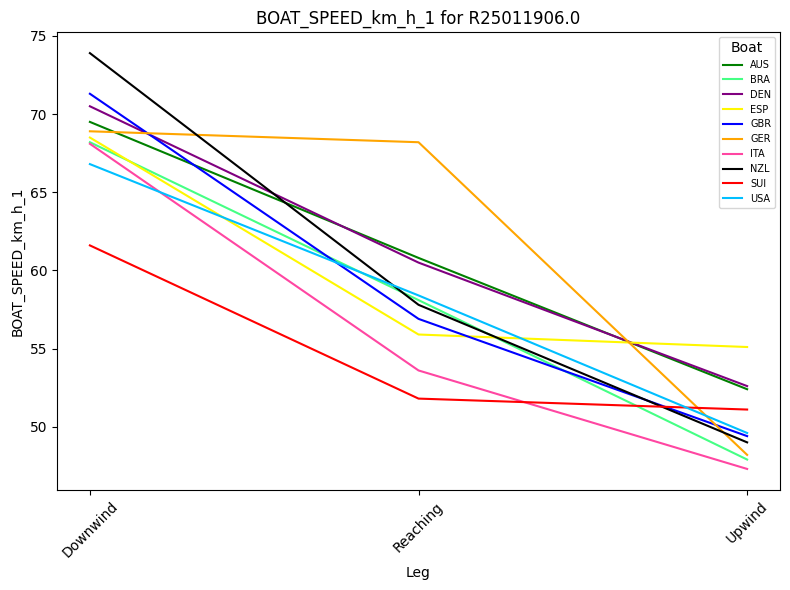

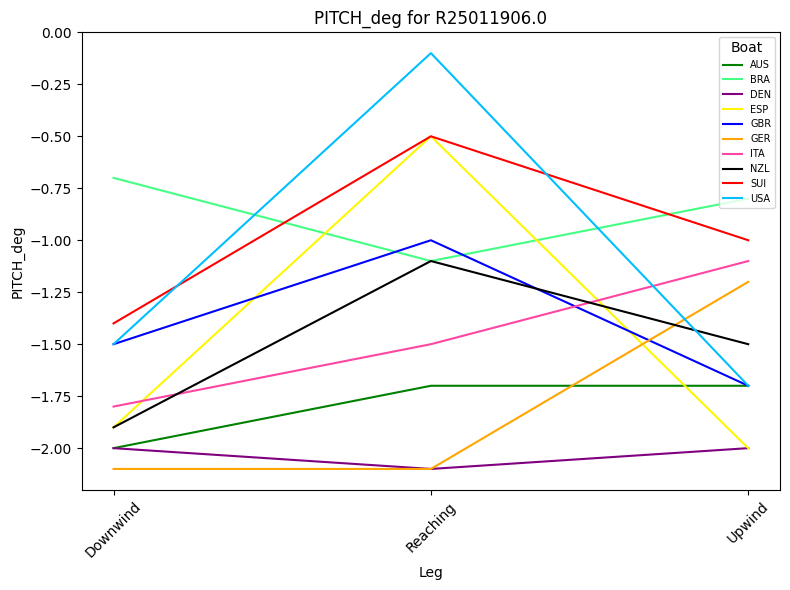

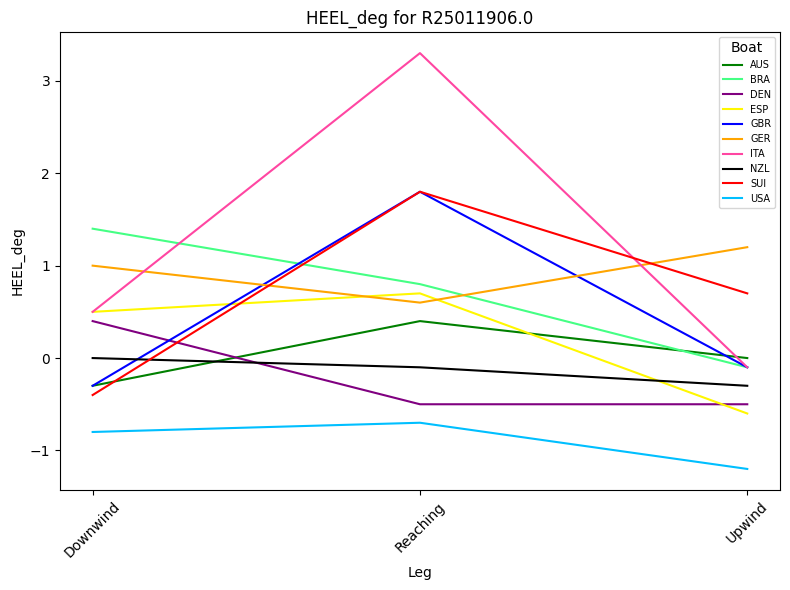

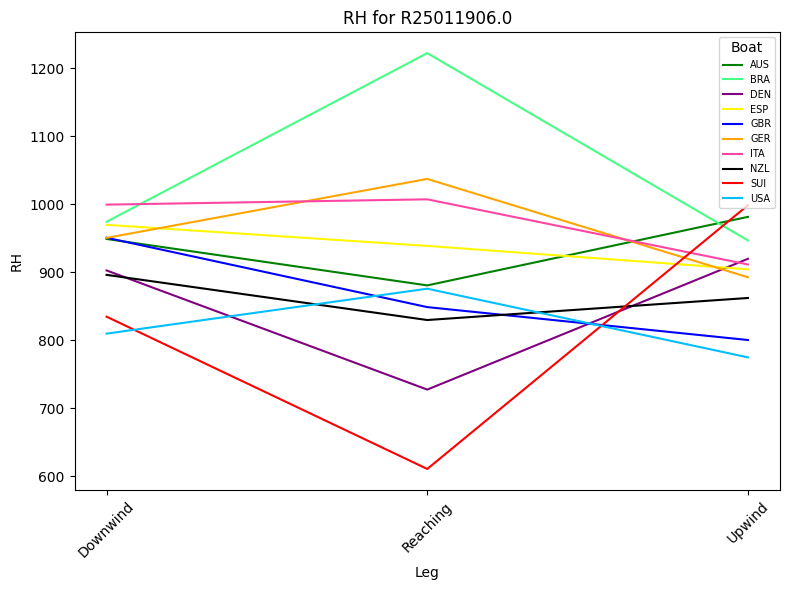

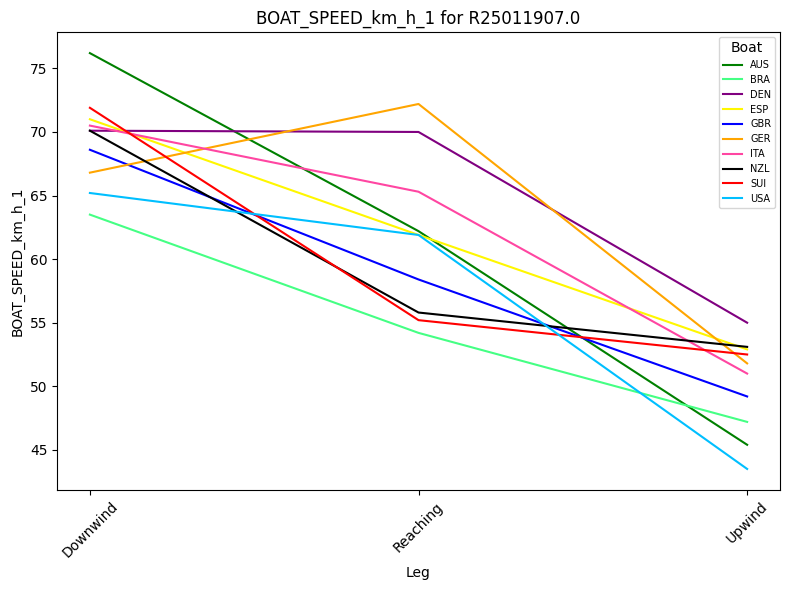

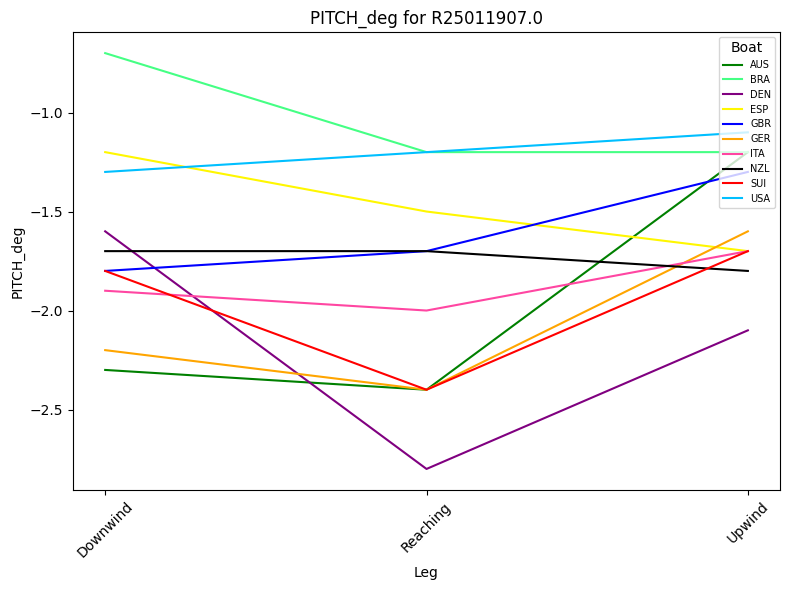

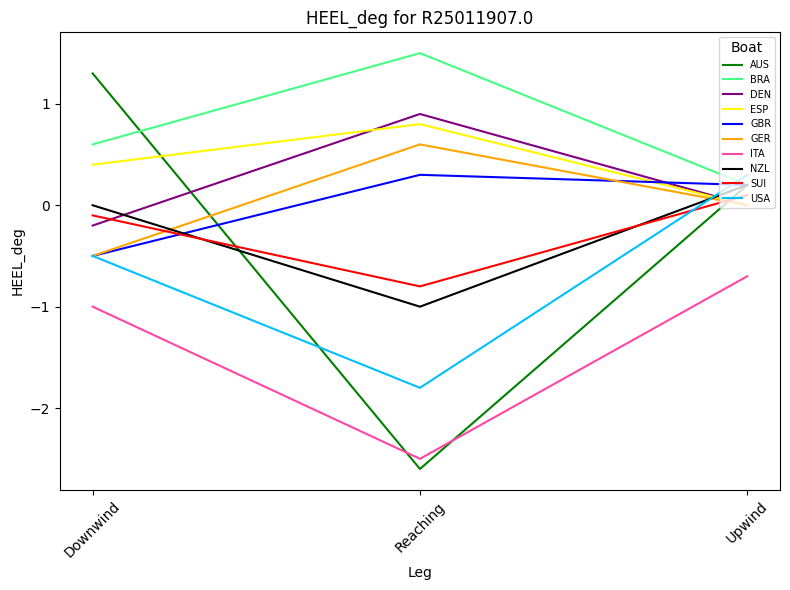

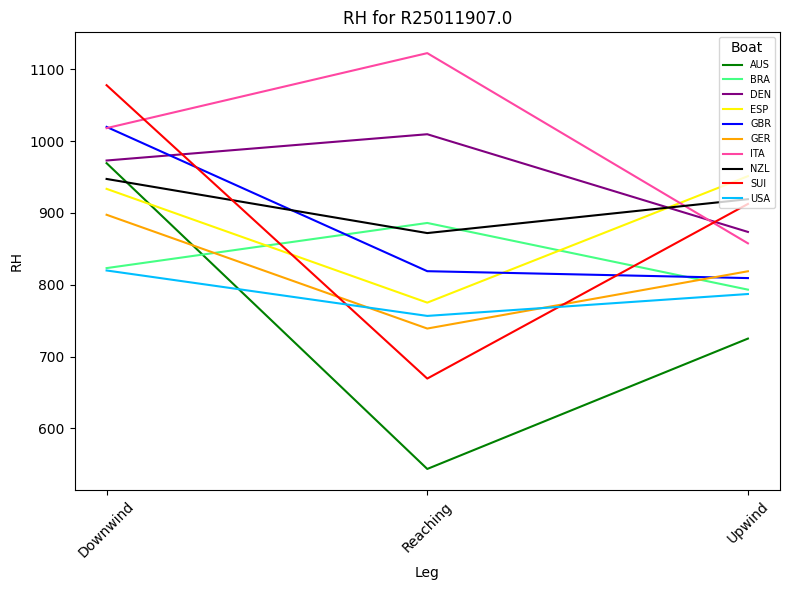

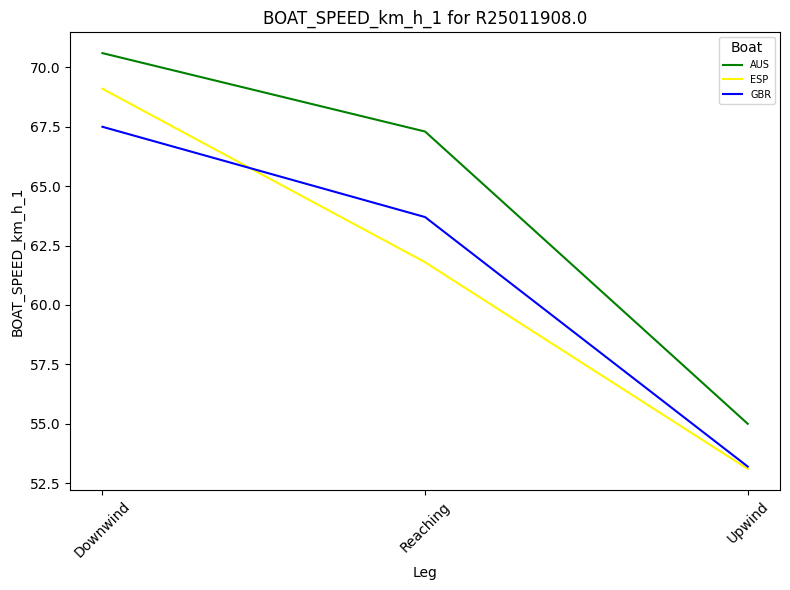

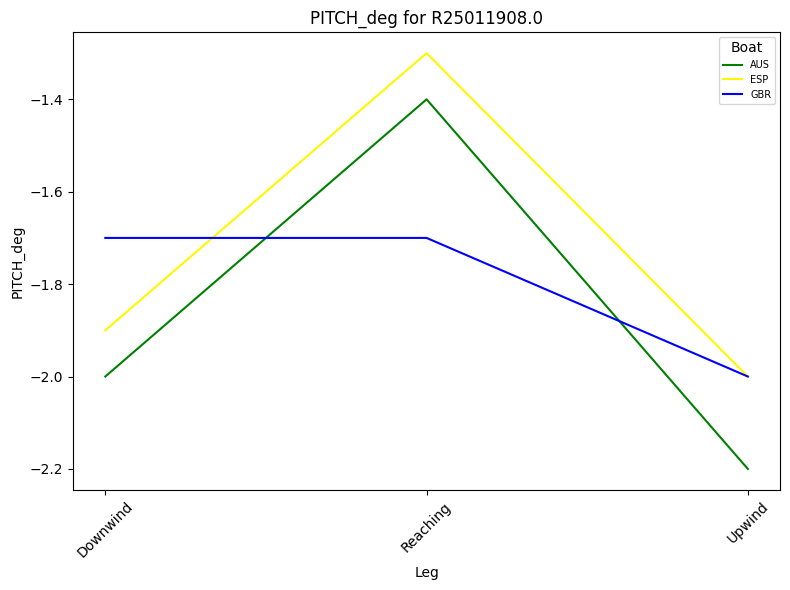

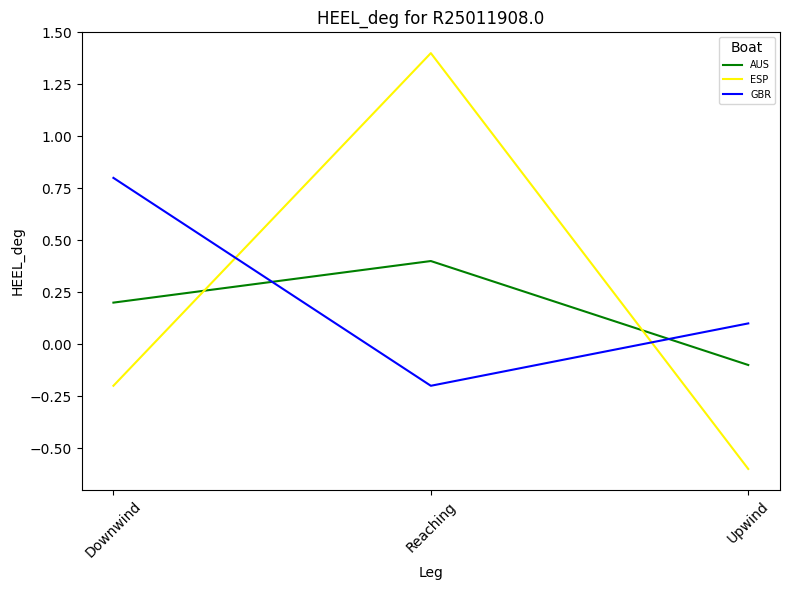

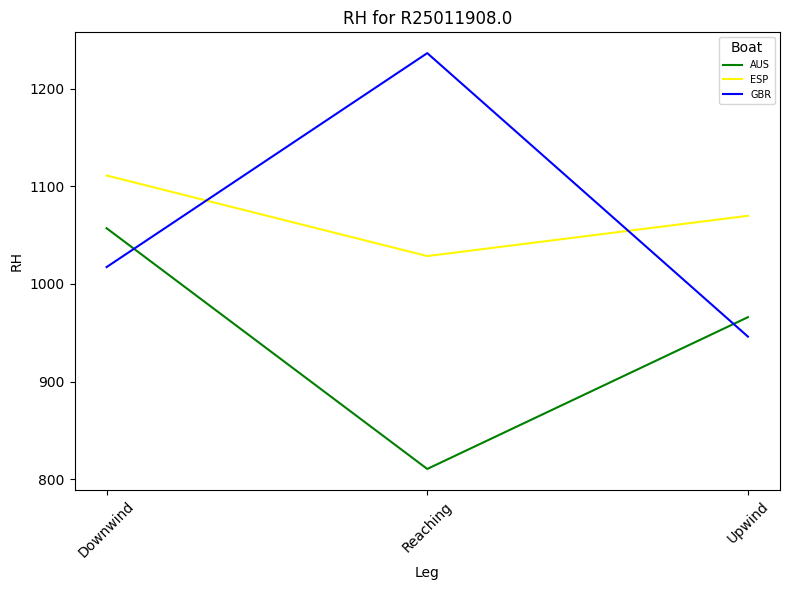

In [38]:
# Plot for each tws_bin group
for race, group in race_leg_averages.groupby('TRK_RACE_NUM_unk'):
    for col in ['BOAT_SPEED_km_h_1', 'PITCH_deg', 'HEEL_deg', 'RH']:
        plt.figure(figsize=(8, 6))
        sns.lineplot(x='leg', y=col, hue='BOAT', data=group, markers=True, errorbar=None, palette=custom_palette)
        plt.title(f"{col} for R{race}")
        plt.legend(title="Boat", loc="upper right", fontsize="7")
        plt.xlabel("Leg")
        plt.ylabel(col)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


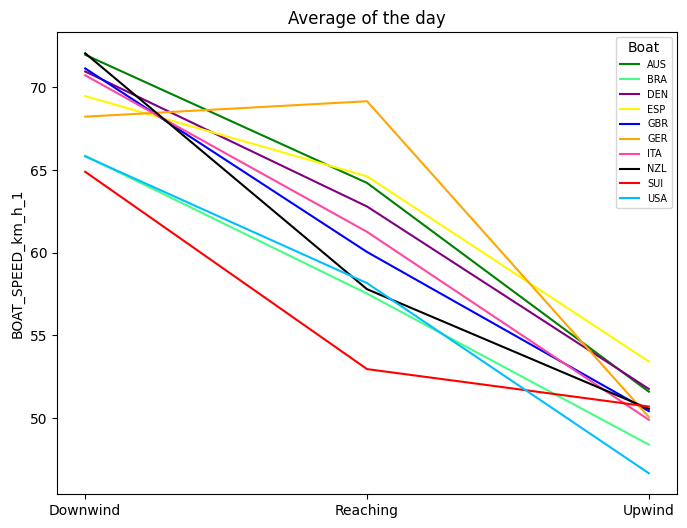

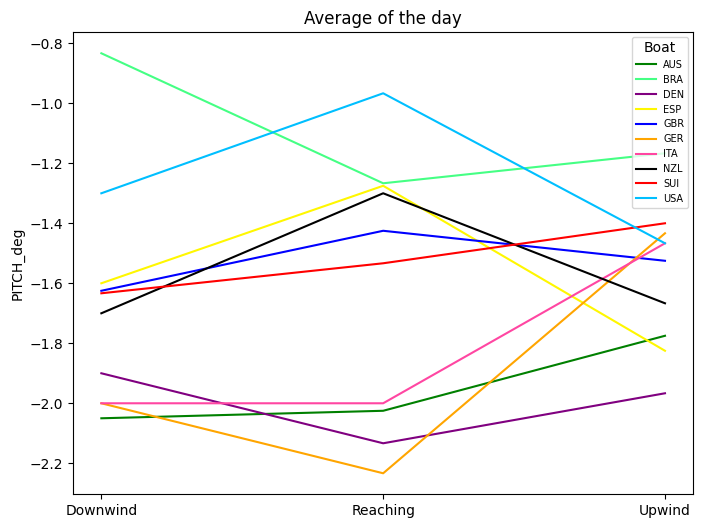

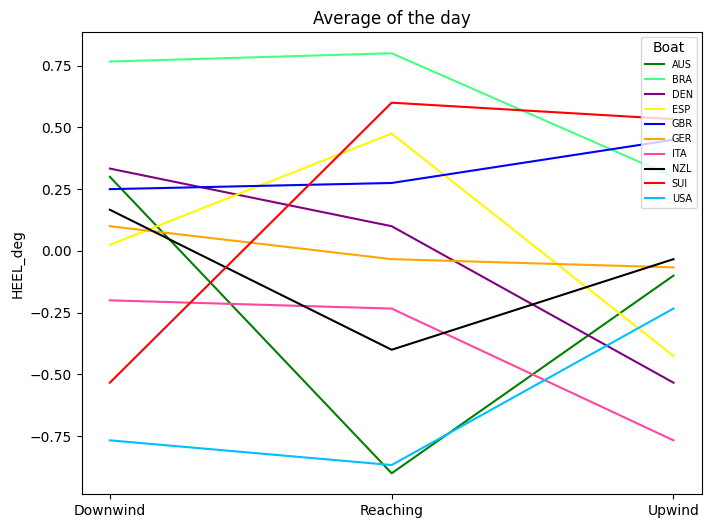

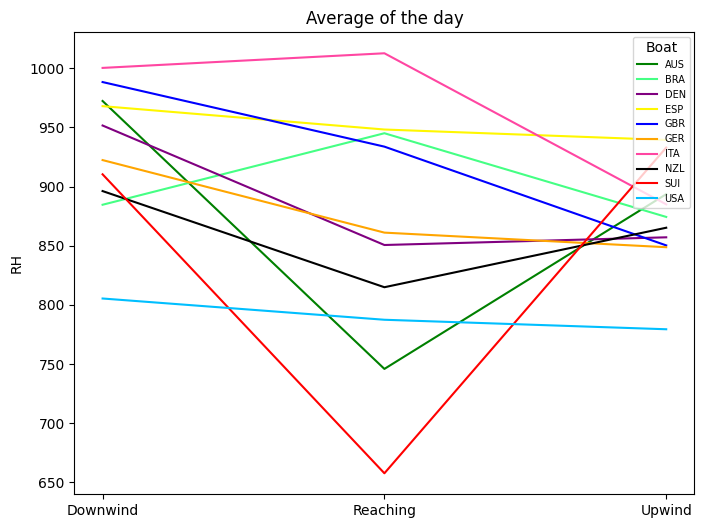

In [39]:
for col in ['BOAT_SPEED_km_h_1',
     'PITCH_deg',
     'HEEL_deg',
     'RH']:
    plt.figure(figsize=(8,6))
    sns.lineplot(x='leg', y=col,hue='BOAT',data=race_leg_averages, markers=True, errorbar=None, palette=custom_palette)
    plt.title("Average of the day")
    plt.legend(title="Boat", loc="upper right",fontsize="7")
    plt.xlabel("")
    plt.show()

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the mean averages per boat and leg for the specified columns
mean_averages_per_boat = race_leg_averages.groupby(['BOAT', 'leg'])[['BOAT_SPEED_km_h_1', 'PITCH_deg', 'HEEL_deg', 'RH']].mean().round(1)

# Display the mean averages per boat and leg
print("Mean Averages per Boat and Leg:")
print(mean_averages_per_boat)

Mean Averages per Boat and Leg:
               BOAT_SPEED_km_h_1  PITCH_deg  HEEL_deg      RH
BOAT leg                                                     
AUS  Downwind               72.0       -2.0       0.3   972.4
     Reaching               64.2       -2.0      -0.9   745.9
     Upwind                 51.6       -1.8      -0.1   893.6
BRA  Downwind               65.9       -0.8       0.8   884.7
     Reaching               57.5       -1.3       0.8   945.1
     Upwind                 48.4       -1.2       0.3   874.4
DEN  Downwind               71.0       -1.9       0.3   951.7
     Reaching               62.8       -2.1       0.1   850.6
     Upwind                 51.8       -2.0      -0.5   857.1
ESP  Downwind               69.5       -1.6       0.0   968.0
     Reaching               64.6       -1.3       0.5   948.3
     Upwind                 53.4       -1.8      -0.4   939.5
GBR  Downwind               71.2       -1.6       0.2   988.4
     Reaching               60.0      

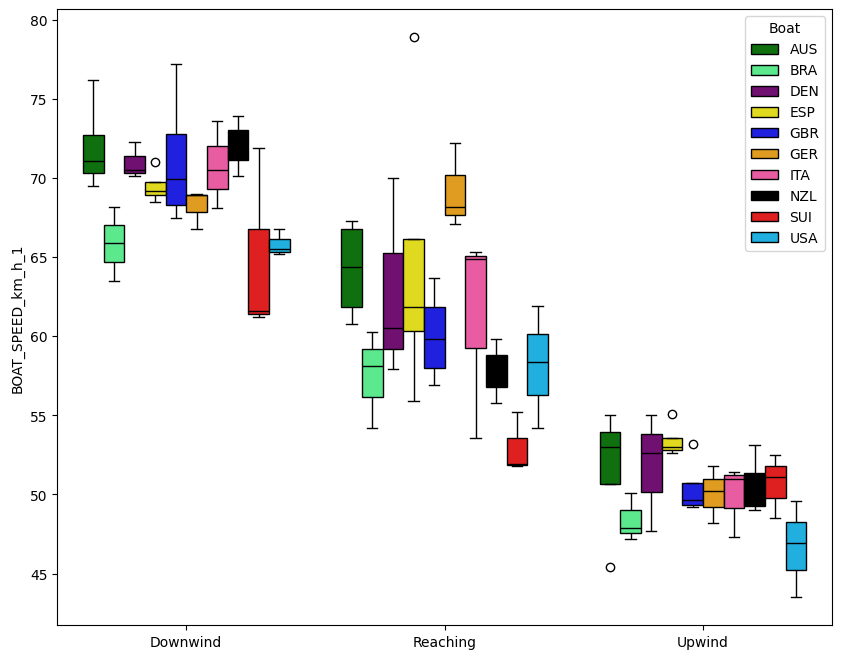

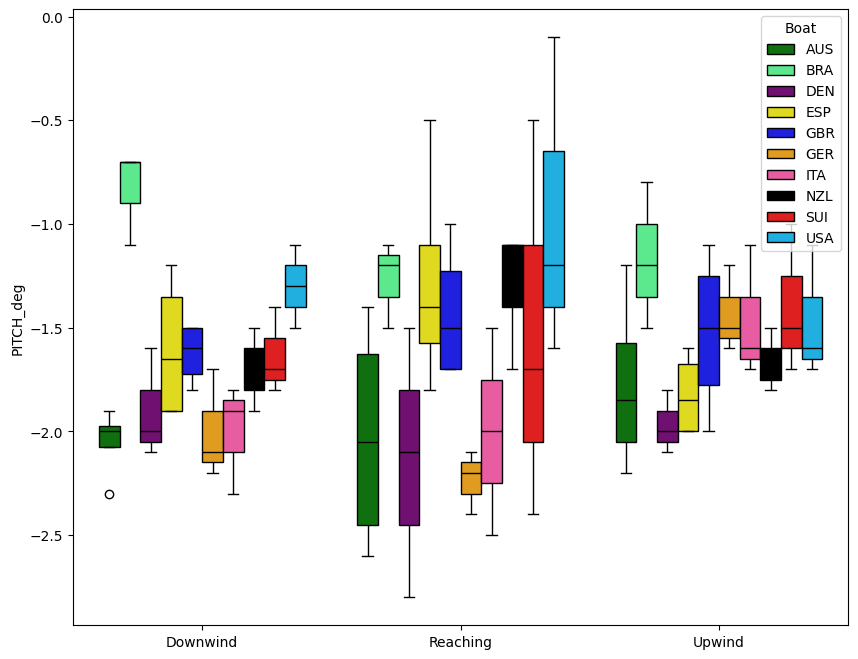

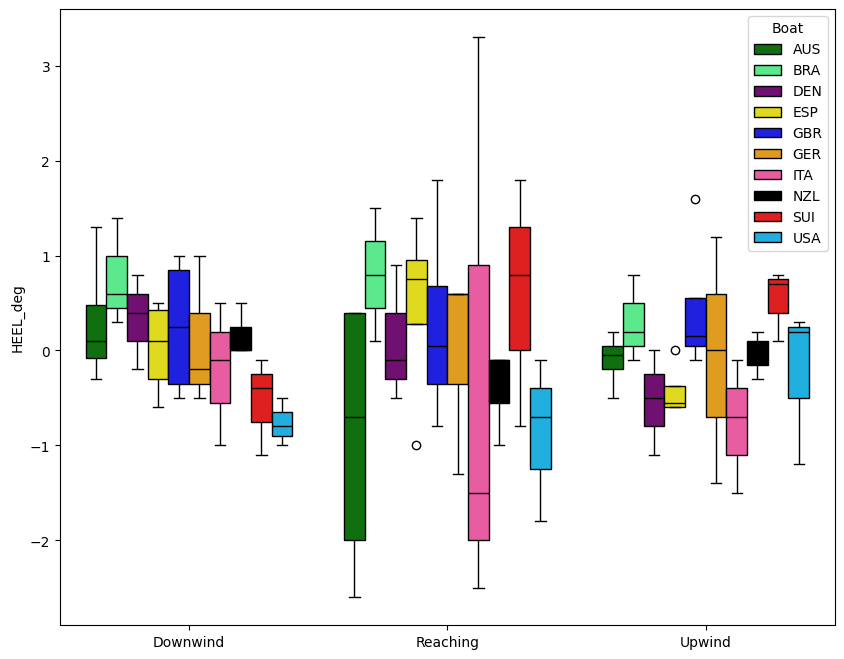

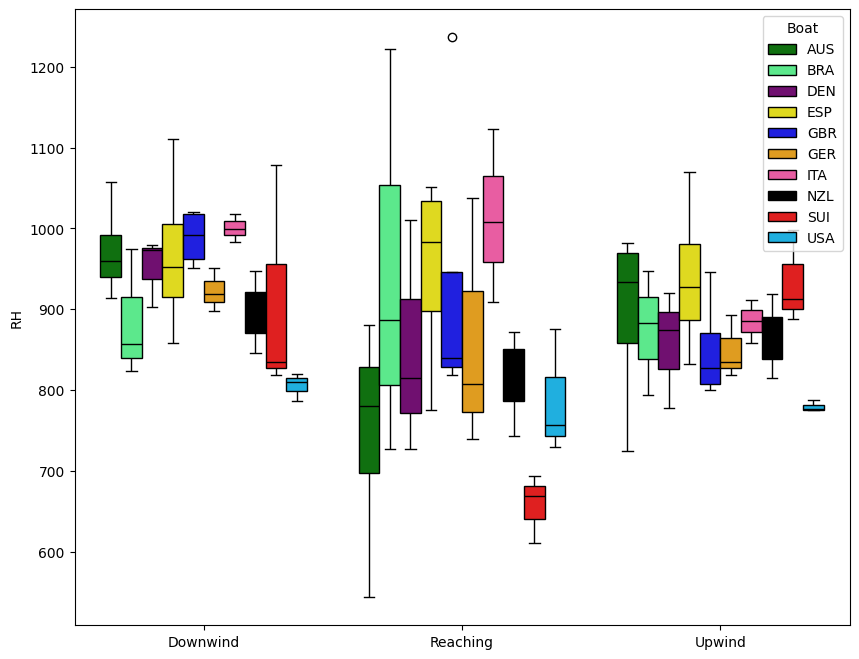

In [41]:

for col in ['BOAT_SPEED_km_h_1',
     'PITCH_deg',
     'HEEL_deg',
     'RH']:
    plt.figure(figsize=(10,8))
    sns.boxplot(x='leg', y=col,hue='BOAT',data=race_leg_averages, palette=custom_palette)
    plt.legend(title="Boat", loc="upper right",fontsize="10")
    plt.xlabel("")
    plt.show()


# **find the averages by result**
in order maybe to find a pattern, for example first boat -- bigger RH


In [43]:
result_averages = df[
    ['BOAT_SPEED_km_h_1','TWA_SGP_deg','AWA_SGP_deg',
    'ANGLE_WING_TWIST_deg', 'ANGLE_WING_ROT_deg','ANGLE_RUDDER_deg', 'ANGLE_RUD_AVG_deg', 'ANGLE_RUD_DIFF_TACK_deg',
     'TRK_RACE_NUM_unk',
     'PITCH_deg','HEEL_deg',
     'RH',
     'result']
].groupby(['TRK_RACE_NUM_unk', 'result']).mean().round(1)

result_averages

BOAT_SPEED_km_h_1  TWA_SGP_deg  AWA_SGP_deg  \
TRK_RACE_NUM_unk result                                                
25011905.0       1                    55.6         -2.8         -2.6   
                 2                    57.0          2.8          0.3   
                 3                    55.8         -7.3         -3.7   
                 4                    54.3         -1.5         -4.2   
                 5                    54.8          0.1         -2.3   
                 6                    54.0         -6.5         -2.5   
                 7                    52.6         -7.2         -8.1   
                 8                    52.9        -12.4         -5.3   
                 9                    50.4         -6.3         -4.3   
                 10                   48.5         -9.9         -8.9   
25011906.0       1                    52.7         -8.1         -3.4   
                 2                    52.5         -9.4        -10.8   
                 3                    53.2        -14.8        -10.5   
                 4                    52.2         -4.4         -4.9   
                 5                    50.4         -7.5         -2.9   
                 6                    48.0          3.7          0.8   
                 7                    50.8         -9.2         -4.1   
                 8                    49.4          2.7          0.8   
                 9                    49.6        -12.9         -7.0   
                 10                   49.1         -6.1         -5.8   
25011907.0       1                    57.1          0.8         -4.3   
                 2                    54.1         -2.3         -4.1   
                 3                    54.9         -9.5         -1.8   
                 4                    55.5          1.7         -1.9   
                 5                    55.2         -4.2         -5.0   
                 6                    53.5         -2.0         -1.4   
                 7                    52.0        -10.2         -7.0   
                 8                    55.4          2.8         -1.8   
                 9                    48.6          1.4         -0.5   
                 10                   47.4         -7.8         -2.9   
25011908.0       1                    56.8         -3.6         -0.6   
                 2                    56.1        -11.2         -3.8   
                 3                    55.5         -1.2         -1.1   

                         ANGLE_WING_TWIST_deg  ANGLE_WING_ROT_deg  \
TRK_RACE_NUM_unk result                                             
25011905.0       1                       -1.0                 0.4   
                 2                       -0.7                -1.1   
                 3                       -0.4                -1.5   
                 4                       -0.2                 0.2   
                 5                        0.6                -3.2   
                 6                        2.8                -0.6   
                 7                       -1.7                -3.1   
                 8                        3.2                -2.4   
                 9                       -0.9                -0.2   
                 10                       1.3                -1.5   
25011906.0       1                        0.2                -1.6   
                 2                        0.2                -3.9   
                 3                       -1.8                -2.6   
                 4                       -3.3                -1.5   
                 5                       -3.6                -0.8   
                 6                        2.4                 5.0   
                 7                       -1.6                -2.5   
                 8                        3.9                -0.2   
                 9                       -0.2                -1.6   
                 10                      -4.7          

In [44]:
df[['BOAT_SPEED_km_h_1', 'result']]

BOAT_SPEED_km_h_1  result
0                 33.49       1
1                 10.42       1
2                 22.98       1
3                 26.68       1
4                 41.58       1
...                 ...     ...
2283              53.74       9
2284              65.05       9
2285              42.56       9
2286              46.04       9
2287              48.25       9

[2288 rows x 2 columns]

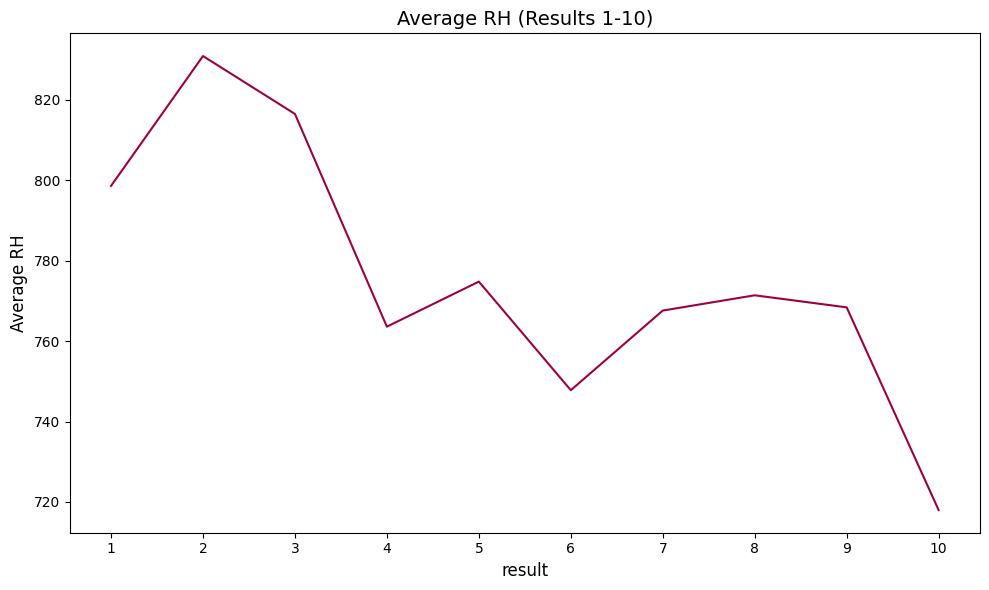

In [104]:
# Define column names
result_col = "result"

# Filter for result values between 1 and 10
df_filtered = df[df[result_col].between(1, 10)]

# Compute averages
bsp_averages = df_filtered.groupby(result_col)['RH'].mean().round(1)

# Plot
plt.figure(figsize=(10, 6))
bsp_averages.plot(kind='line', colormap='Spectral')

# Formatting
plt.title(f"Average RH (Results 1-10)", fontsize=14)
plt.xlabel(result_col, fontsize=12)
plt.ylabel("Average RH", fontsize=12)
plt.xticks(range(1, 11))

# Show the plot
plt.tight_layout()
plt.show()


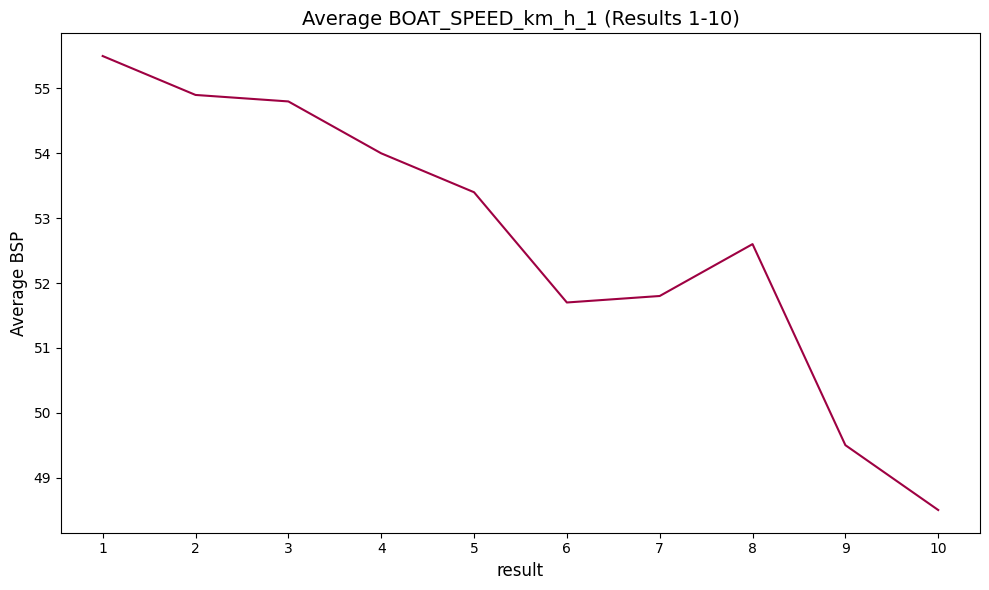

In [103]:
result_col = "result"

# Filter for result values between 1 and 10
df_filtered = df[df[result_col].between(1, 10)]

# Compute averages
bsp_averages = df_filtered.groupby(result_col)['BOAT_SPEED_km_h_1'].mean().round(1)

# Plot
plt.figure(figsize=(10, 6))
bsp_averages.plot(kind='line', colormap='Spectral')

# Formatting
plt.title("Average BOAT_SPEED_km_h_1 (Results 1-10)", fontsize=14)
plt.xlabel(result_col, fontsize=12)
plt.ylabel("Average BSP", fontsize=12)
plt.xticks(range(1, 11))

# Show the plot
plt.tight_layout()
plt.show()


# **Rudder angles**

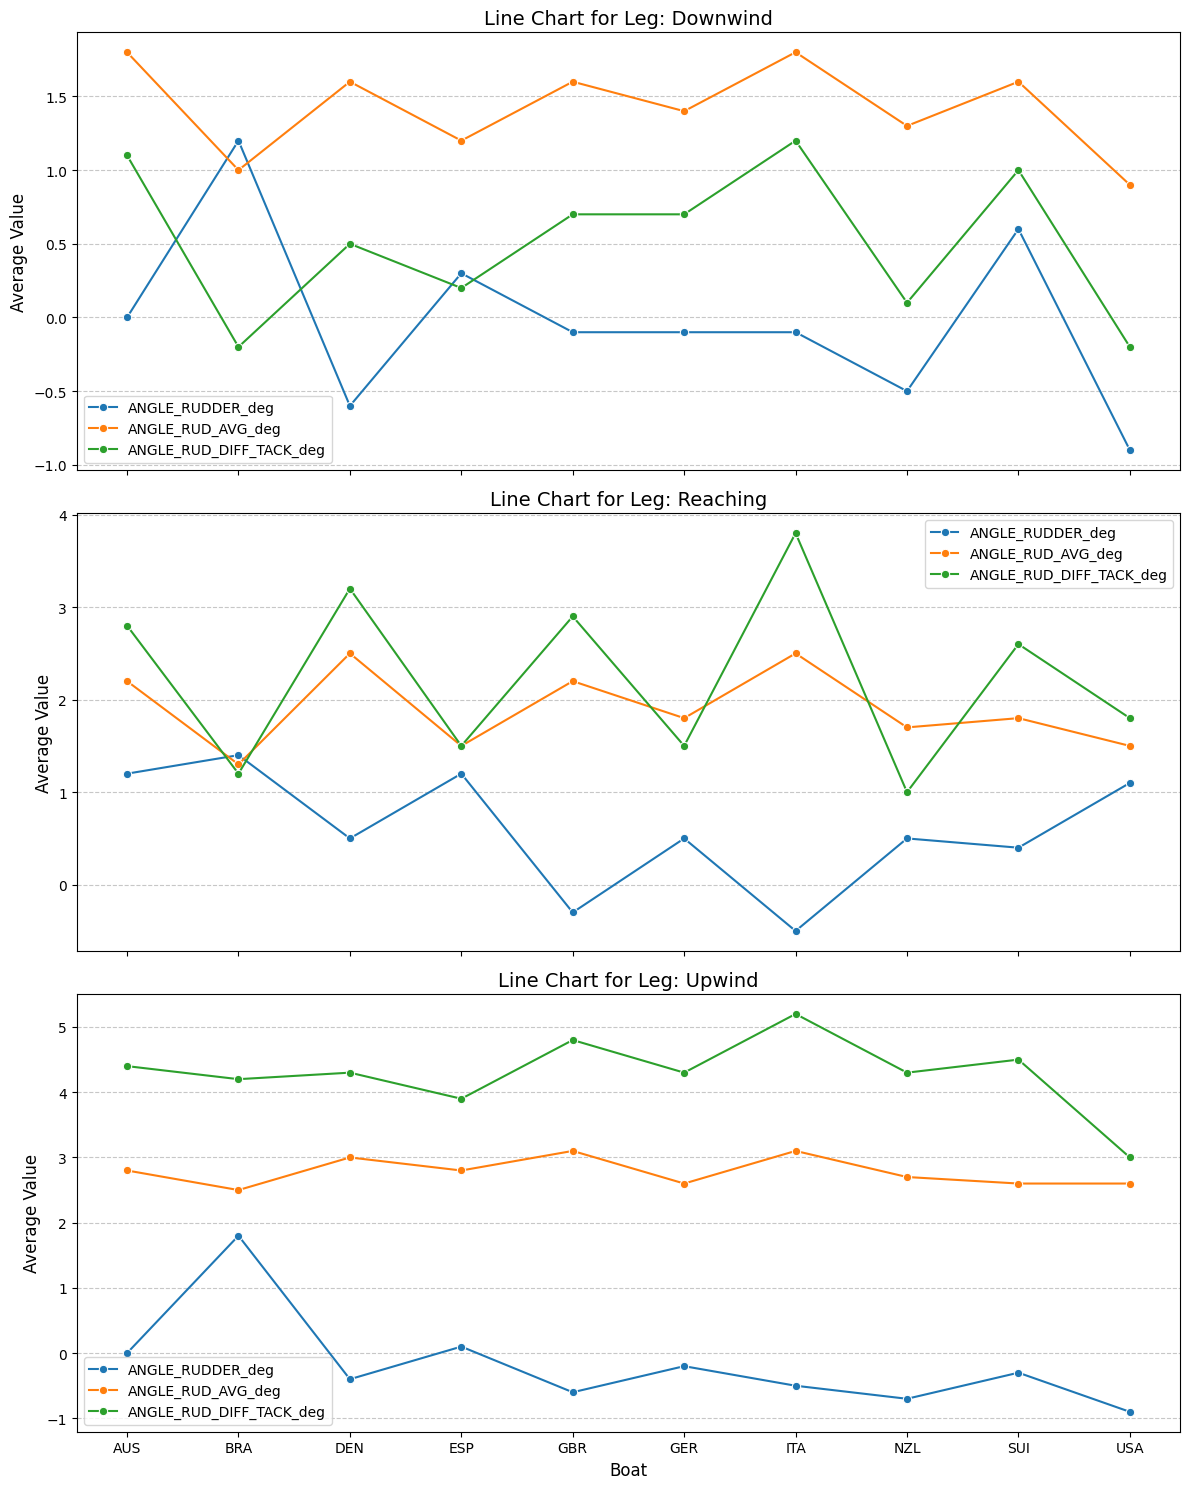

In [109]:
# Create line plots for each leg
fig, axes = plt.subplots(len(unique_legs), 1, figsize=(12, 5 * len(unique_legs)), sharex=True)

if len(unique_legs) == 1:
    axes = [axes]

# Loop through each leg and plot line graphs
for ax, leg in zip(axes, unique_legs):
    leg_data = rudder_averages[rudder_averages['leg'] == leg]
    
    # Plot line graph for each metric
    for metric in ['ANGLE_RUDDER_deg', 'ANGLE_RUD_AVG_deg', 'ANGLE_RUD_DIFF_TACK_deg']:
        sns.lineplot(
            x='BOAT', y=metric, data=leg_data, marker='o', ax=ax, label=metric
        )
    
    # Formatting
    ax.set_title(f"Line Chart for Leg: {leg}", fontsize=14)
    ax.set_xlabel("Boat", fontsize=12)
    ax.set_ylabel("Average Value", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


**To be performed if windward leeward values for DBs---**

# Create line plots for each leg
fig, axes = plt.subplots(len(unique_legs), 1, figsize=(12, 5 * len(unique_legs)), sharex=True)

if len(unique_legs) == 1:
    axes = [axes]

# Loop through each leg and plot line graphs
for ax, leg in zip(axes, unique_legs):
    leg_data = foil_averages[foil_averages['leg'] == leg]
    
    # Plot line graph for each metric
    for metric in ['ANGLE_DB_RAKE_P_deg', 'ANGLE_DB_RAKE_S_deg', 'ANGLE_DB_CANT_P_deg', 'ANGLE_DB_CANT_S_deg']:
        sns.lineplot(
            x='result', y=metric, data=leg_data, marker='o', ax=ax, label=metric
        )
    
    # Formatting
    ax.set_title(f"Line Chart for Leg: {leg}", fontsize=14)
    ax.set_xlabel("Result (Finishing Position)", fontsize=12)
    ax.set_ylabel("Average Value", fontsize=12)
    ax.legend(title="Metrics")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Flight time

In [71]:
fly=df_merged.groupby(['BOAT', 'TRK_RACE_NUM_unk'])['flying'].sum()
total=df_merged.groupby(['BOAT', 'TRK_RACE_NUM_unk'])['flying'].count()
# Calculate the percentage of flying time for each boat
flighttime_percentage= ((fly / total) * 100).round(2).reset_index()

In [72]:
flighttime_percentage['race']=flighttime_percentage['TRK_RACE_NUM_unk'].apply(lambda x: int(str(x)[7])) #setting race as a number 

In [85]:
flighttime_percentage.groupby(['BOAT']).mean().sort_values('flying',ascending=False)

TRK_RACE_NUM_unk      flying  race
BOAT                                    
USA         25011906.0  100.000000   6.0
GBR         25011906.5   97.862500   6.5
AUS         25011906.5   97.070000   6.5
BRA         25011906.0   96.273333   6.0
ITA         25011906.0   95.436667   6.0
ESP         25011906.5   95.282500   6.5
NZL         25011906.0   94.860000   6.0
GER         25011906.0   94.396667   6.0
SUI         25011906.0   91.946667   6.0
DEN         25011906.0   91.443333   6.0

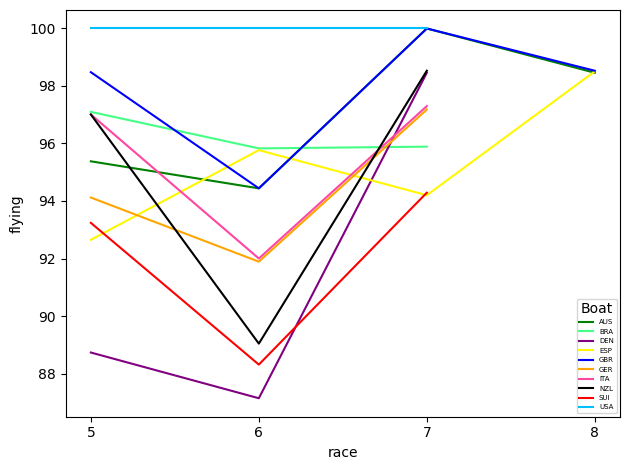

In [73]:
plt.figure()

sns.lineplot(x='race', y='flying', hue='BOAT', data=flighttime_percentage,  errorbar=None, palette=custom_palette)
        
# Adding titles and labels
plt.legend(title="Boat", loc="lower right", fontsize="5")
plt.xticks(ticks=[5,6,7,8])
plt.tight_layout()
plt.show()

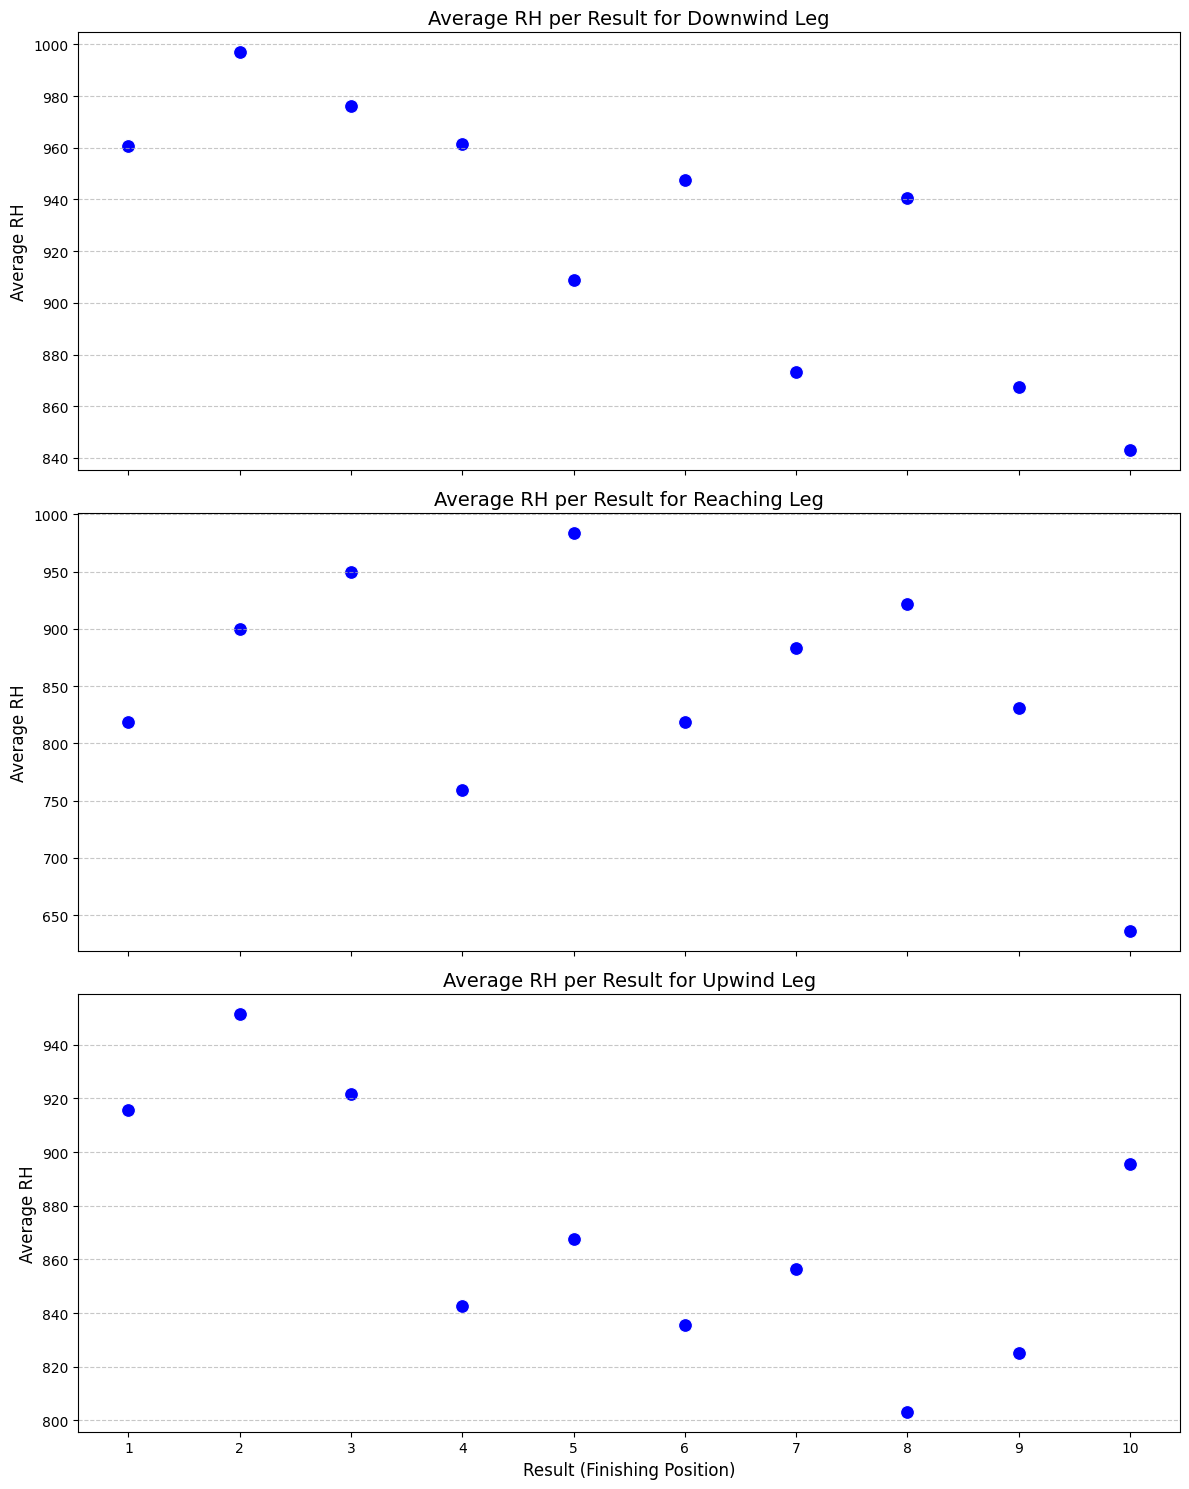

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group data by "leg" and "result" and compute the mean for 'LENGTH_RH_BOW_mm'
height_averages = df[['RH', 'leg', 'result']].groupby(['leg', 'result']).mean().round(1)

# Reset index for easier plotting
height_averages = height_averages.reset_index()

# Get unique legs for separate plots
unique_legs = height_averages['leg'].unique()

# Create subplots for each leg
fig, axes = plt.subplots(len(unique_legs), 1, figsize=(12, 5 * len(unique_legs)), sharex=True)

# Ensure axes is iterable (needed when there's only one unique leg)
if len(unique_legs) == 1:
    axes = [axes]

# Loop through each unique leg and plot separately
for ax, leg in zip(axes, unique_legs):
    # Filter data for the current leg
    leg_data = height_averages[height_averages['leg'] == leg]
    
    # Plot the data for this leg only
    sns.scatterplot(x=leg_data['result'], y=leg_data['RH'], ax=ax, color='blue', s=100)

    # Formatting
    ax.set_title(f"Average RH per Result for {leg} Leg", fontsize=14)
    ax.set_xlabel("Result (Finishing Position)", fontsize=12)
    ax.set_ylabel("Average RH", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticks(range(int(leg_data['result'].min()), int(leg_data['result'].max()) + 1)) 

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


# Wing

In [ ]:
# Define a function for rolling circular mean
def rolling_circmean(data, window):
    return data.rolling(window=window).apply(lambda x: circmean(x, high=360, low=0), raw=True)
#function to define  and adjust the variables that need to be adjusted for tacks
def adjust_angles(df):
    adjusted_df=df.copy()
    # Define the columns whose signs need to be changed
    angle_columns = [
        'TWA_SGP_deg', 'AWA_SGP_deg','LEEWAY_deg',
        'ANGLE_CA1_deg', 'ANGLE_CA2_deg', 'ANGLE_CA3_deg', 'ANGLE_CA4_deg', 
        'ANGLE_CA5_deg', 'ANGLE_CA6_deg', 'ANGLE_WING_TWIST_deg', 'ANGLE_WING_ROT_deg','HEEL_deg'
    ]
    #Add a column to keep the record of the tack 
    adjusted_df['tack']=np.where(adjusted_df['TWA_SGP_deg'] < 0, 'P', 'S')
    
    # Apply the sign change conditionally for each row where P tack--> TWA_SGP_deg < 0
    mask = adjusted_df['TWA_SGP_deg'] < 0
    adjusted_df.loc[mask, angle_columns] = adjusted_df.loc[mask, angle_columns] * -1
    adjusted_df['RATE_YAW_deg_s_1'] = adjusted_df['RATE_YAW_deg_s_1'].abs()  # YAW rate sign depends on whether turning clock or anti clock wise, so decided to get its absolute value

    return adjusted_df

In [ ]:
df_wing=adjust_angles(df_merged)
df_wing = df_wing[df_wing['BOAT'] != 'CAN']
plt.xticks(ticks=[5,6,7,8])
df_wing['race']=df_wing['TRK_RACE_NUM_unk'].apply(lambda x: int(str(x)[7])) #setting race as a number 
df_wing.loc[df['TRK_LEG_NUM_unk'].isin([2, 4, 6]), 'leg'] = 'Downwind'
df_wing.loc[df['TRK_LEG_NUM_unk'].isin([3, 5]), 'leg'] = 'Upwind'
df_wing.loc[df['TRK_LEG_NUM_unk'].isin([1, 7]), 'leg'] = 'Reaching'


C:\Users\matsa\AppData\Local\Temp\ipykernel_21396\3272708774.py:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Downwind' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [ ]:
df_wing.columns

Index(['BOAT', 'TIME_LOCAL_unk', 'LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk',
       'BOAT_SPEED_km_h_1', 'GPS_SOG_km_h_1', 'HEADING_deg', 'TWA_SGP_deg',
       'TWS_SGP_km_h_1', 'TWD_SGP_deg', 'AWA_SGP_deg', 'RATE_YAW_deg_s_1',
       'GPS_COG_deg', 'LEEWAY_deg', 'VMG_km_h_1', 'ANGLE_CA1_deg',
       'ANGLE_CA2_deg', 'ANGLE_CA3_deg', 'ANGLE_CA4_deg', 'ANGLE_CA5_deg',
       'ANGLE_CA6_deg', 'ANGLE_WING_TWIST_deg', 'ANGLE_WING_ROT_deg',
       'PITCH_deg', 'HEEL_deg', 'LENGTH_RH_P_mm', 'LENGTH_RH_S_mm',
       'LENGTH_RH_BOW_mm', 'ANGLE_RUDDER_deg', 'ANGLE_RUD_AVG_deg',
       'ANGLE_RUD_DIFF_TACK_deg', 'ANGLE_DB_RAKE_P_deg', 'ANGLE_DB_RAKE_S_deg',
       'ANGLE_DB_CANT_P_deg', 'ANGLE_DB_CANT_S_deg', 'TRK_LEG_NUM_TOT_unk',
       'TRK_LEG_NUM_unk', 'TRK_RACE_NUM_unk', 'PC_TTS_s', 'PC_TTK_s',
       'PC_TTB_s', 'PC_DTB_m', 'PC_DTL_m', 'PC_TTM_s', 'TWD_avg', 'DATETIME',
       'TWA', 'TTL', 'RH', 'time_diff', 'acc', 'flying', 'tws_bins', 'result',
       'LATITUDE_deg_FL1', 'LATITUDE_deg_FL2

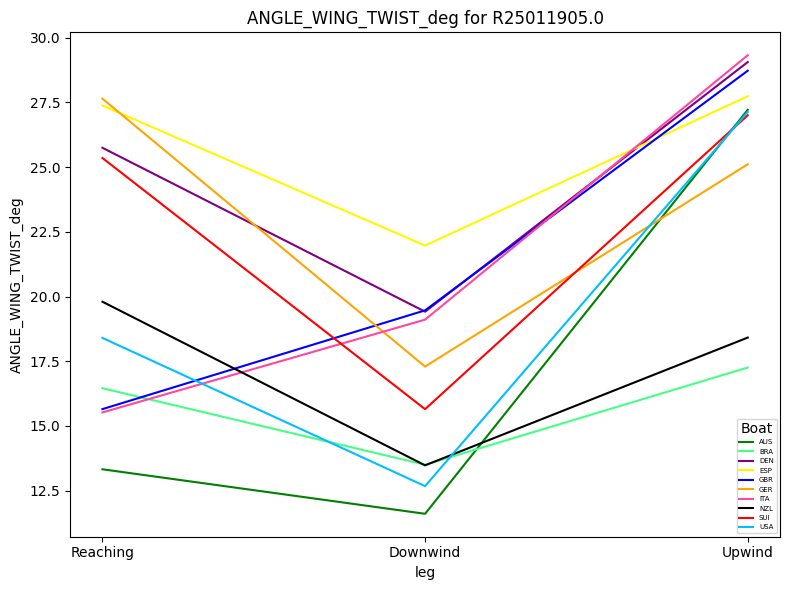

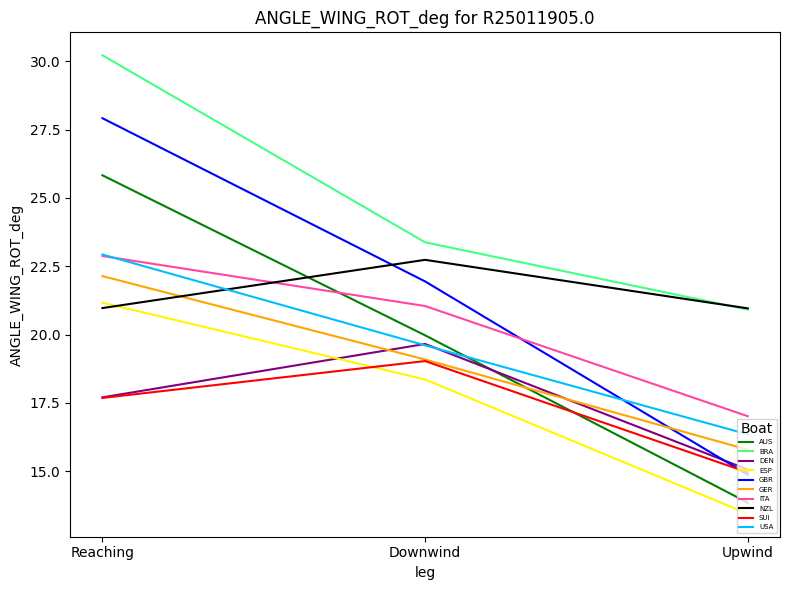

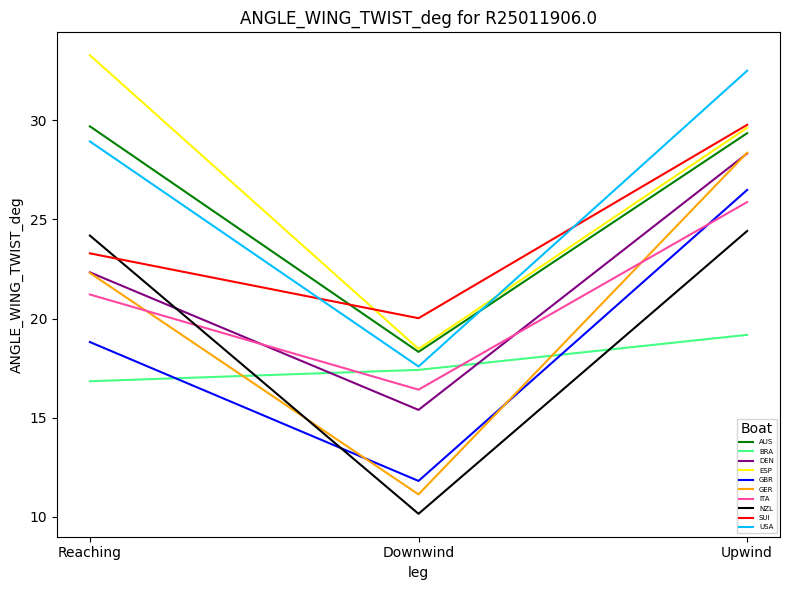

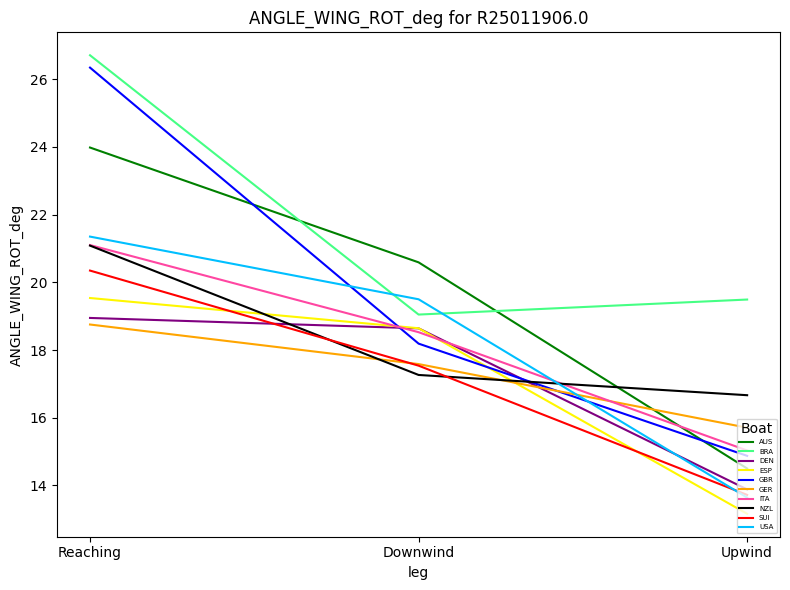

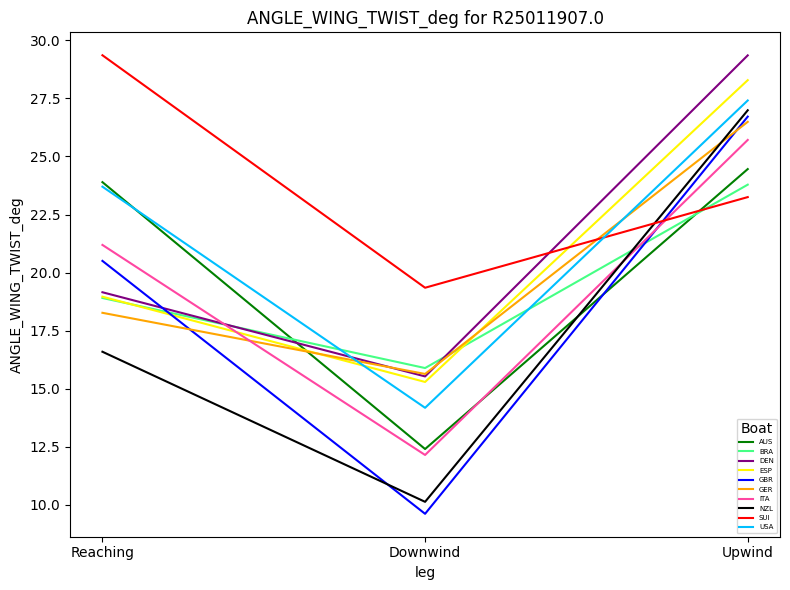

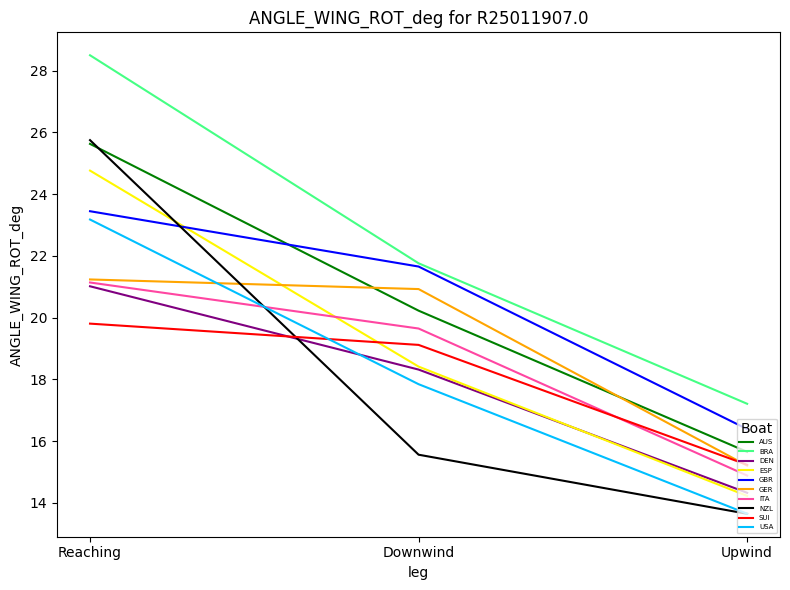

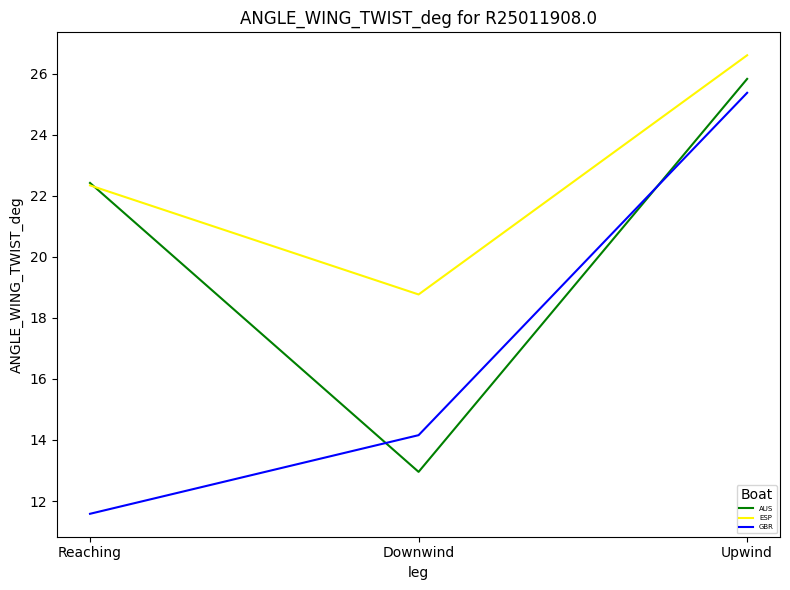

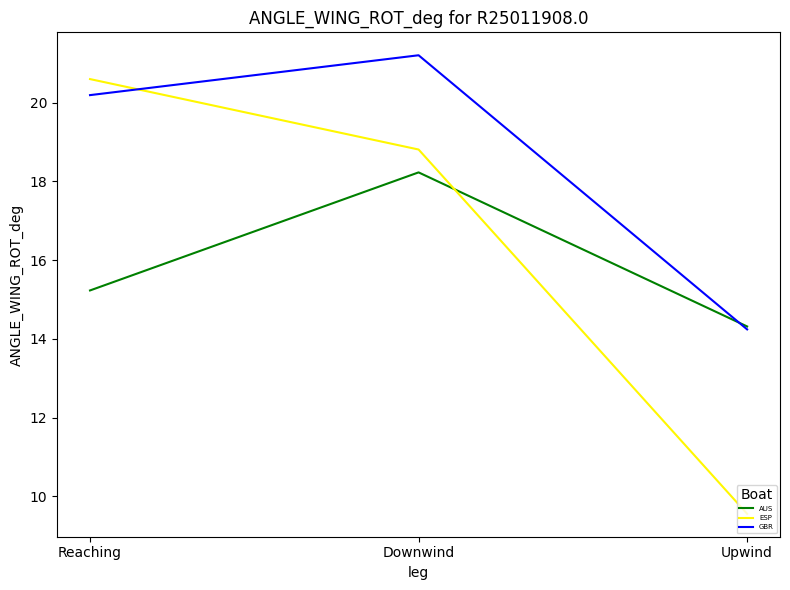

In [ ]:
for race, group in df_wing.groupby('TRK_RACE_NUM_unk'):
    # Looping through the specified columns
    for col in ['ANGLE_WING_TWIST_deg', 'ANGLE_WING_ROT_deg']:
        # Creating a new figure for each plot
        plt.figure(figsize=(8, 6))
        
        sns.lineplot(x='leg', y=col, hue='BOAT', data=group, markers=True, errorbar=None, palette=custom_palette)
        
        # Adding titles and labels
        plt.title(f"{col} for R{race}")
        plt.legend(title="Boat", loc="lower right", fontsize="5")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()


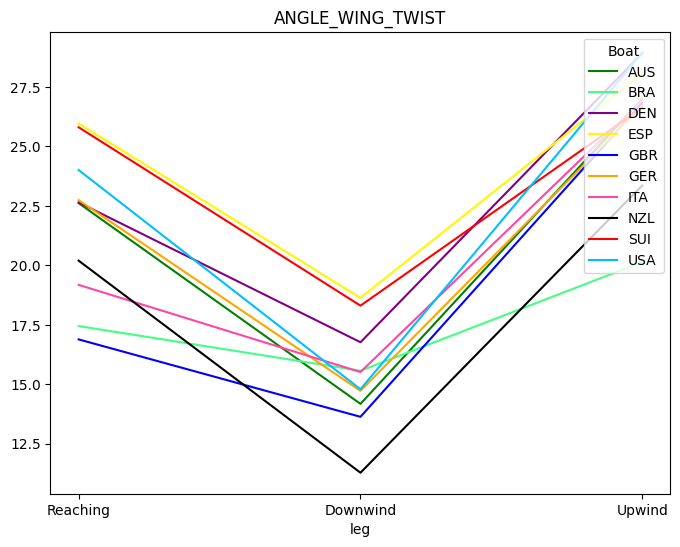

In [ ]:
plt.figure(figsize=(8,6))
# Use seaborn's barplot to plot the count of tacks/jibes for each TRK_RACE_NUM_unk and BOAT combination
sns.lineplot(x="leg", y='ANGLE_WING_TWIST_deg', hue="BOAT", data=df_wing, markers='o',errorbar=None,  palette=custom_palette)

# Adding labels and title
plt.title("ANGLE_WING_TWIST")
plt.axis('tight')
plt.ylabel("")
plt.legend(title="Boat", loc="upper right")

plt.show()

In [ ]:
df_final_race

NameError: name 'df_final_race' is not defined

In [ ]:
df_final_race['leg'].unique()

In [ ]:
df_final_race = df_wing[df_wing['race'] == 8].dropna()
plt.figure(figsize=(10,8))
# Use seaborn's barplot to plot the count of tacks/jibes for each TRK_RACE_NUM_unk and BOAT combination
sns.scatterplot(x="ANGLE_WING_ROT_deg", y='ANGLE_WING_TWIST_deg', hue="BOAT",  style="leg", data=df_final_race, palette=custom_palette,markers=True, s=100)

# Adding labels and title
plt.title("ANGLE_WING_TWIST")
plt.axis('tight')
plt.ylabel("")
plt.legend( loc="lower right")

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_final_race is already filtered for race 8 and cleaned

# Get unique legs in the dataset
unique_legs = df_final_race['leg'].unique()

# Loop through each leg and create a separate figure
for leg in unique_legs:
    # Filter data for the specific leg
    df_leg = df_final_race[df_final_race['leg'] == leg]
    
    # Set up a new figure for each leg
    plt.figure(figsize=(10, 8))

    # Create scatter plot for this leg
    sns.scatterplot(x="ANGLE_WING_ROT_deg", y="ANGLE_WING_TWIST_deg", 
                    hue="BOAT", data=df_leg, palette=custom_palette, markers=True, s=100)
    
    # Add labels and title
    plt.title(f"ANGLE_WING_TWIST_deg vs ANGLE_WING_ROT_deg for Leg {leg}")
    plt.xlabel("ANGLE_WING_ROT_deg")
    plt.ylabel("ANGLE_WING_TWIST_deg")
    plt.legend(title="Boat", loc="lower right", fontsize=10)

    # Show the plot for this leg
    plt.tight_layout()
    plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Plot for ANGLE_WING_TWIST_deg
sns.lineplot(x="DATETIME", y="ANGLE_WING_TWIST_deg",
             hue="BOAT",
             palette="deep", errorbar=None,
             data=df_final_race)

# Create another line plot for ANGLE_WING_ROT_deg, using a secondary y-axis
ax2 = plt.gca().twinx()  # This creates a second y-axis
sns.lineplot(x="DATETIME", y="ANGLE_WING_ROT_deg", 
             hue="BOAT",linestyle='--', 
             palette="muted", errorbar=None,
             data=df_final_race, ax=ax2)

# Adding labels and title
plt.title("ANGLE_WING_TWIST_deg and ANGLE_WING_ROT_deg over Time")
plt.xlabel("Datetime")
plt.ylabel("ANGLE_WING_TWIST_deg")
ax2.set_ylabel("ANGLE_WING_ROT_deg")  # Set the label for the second y-axis

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
# Loop through each boat's data to plot the lines  
#would be better if averaging for each leg


for boat_name in df_final_race['BOAT'].unique():
    boat_data = df_final_race[df_final_race['BOAT'] == boat_name]
    fig.add_trace(go.Scatterpolar(
        r=boat_data['BOAT_SPEED_km_h_1'], 
        theta=boat_data['TWA'], 
        mode='lines+markers',  # Lines and markers
        name=boat_name,  # Add boat name in the legend
        line=dict(width=2),  # Line width
    ))

# Update the layout with the correct axis titles and rotation
fig.update_layout(
    title="Polar Plot for All Boats (Averages with Lines)",
    polar=dict(
        radialaxis=dict(title='Boat Speed (km/h)', showticklabels=True),
        angularaxis=dict(
            showticklabels=True,
            rotation=90,  # Rotate so 0 is at the top and 90 is to the right
            tick0=0,  # Starting tick
            dtick=45,  # Spacing between ticks
            direction='clockwise'
        )
    ),
    showlegend=True  # Show legend with boat names
)

# Show the figure
fig.show()
